In [1]:
#Nice figures for the surface affinities paper

import sys, os
import subprocess
import glob
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib notebook


In [2]:
#Load in all of the data 
#Means data for solvation in bulk first

#Define a base directory to work with - reduces typing
baseDir = './data'

#Want to first read in bulk free energies for all solutes
bulkdGFiles = glob.glob('%s/*/bulk/all_dGs.txt'%baseDir)
bulkdGFiles.sort()
solNames = []
bulkdGs = {}

#And solvation free energies in bulk octanol
octdGs = {}

#And free energies decomposed into electrostatic and LJ terms
bulkdGq = {}
bulkdGlj = {}
bulkdGwca = {}
bulkdGattr = {}

#And while at it, also read in solute-system energies decomposed into LJ and electrostatic components
#Evaluated in fully coupled state, as well as average in states necessary to look compute component-wise relative entropies
bulkSolEnergies = {}
bulkAvgU = {}
bulkAvgUq = {}
bulkAvgUlj = {}
bulkAvgUwca = {}
bulkAvgUattr = {}

#And relative entropies for each step, too
bulkSrel = {}
bulkSrelQ = {}
bulkSrelLJ = {}
bulkSrelWCA = {}
bulkSrelAttr = {}

for afile in bulkdGFiles:
    
    thisSol = afile.split('/bulk')[0].split('/')[-1]
    
    #For now excluding zwitterionic diglycine
    if thisSol == 'zwitterGLY':
        continue
    
    solNames.append(thisSol)
    
    #Bulk water solvation free energies
    thisdGs = np.loadtxt(afile)
    thisavg = np.average(thisdGs)
    thisstd = np.std(thisdGs, ddof=1)
    bulkdGs[thisSol] = np.array([thisavg, thisstd])
    
    #Bulk octanol solvation free energies
    thisOctdGs = np.loadtxt('%s/octanol_solvation/%s/all_dGs.txt'%(baseDir, thisSol))
    thisOctavg = np.average(thisOctdGs)
    thisOctstd = np.std(thisOctdGs, ddof=1)
    octdGs[thisSol] = np.array([thisOctavg, thisOctstd])
    
    #Solute-system electrostatic and LJ energies
    #Evaluated both in fully coupled state and so can compute relative entropy of electrostatic and LJ dG contributions
    energiesText = subprocess.check_output("grep energy %s/%s/bulk/run1/sol_structure.o*"%(baseDir, thisSol), 
                                           stderr=subprocess.STDOUT, shell=True)
    thisEnergies = energiesText.strip().split('\n')
    thisEnergies = [x.split(':')[-1].strip().split('+/-') for x in thisEnergies]
    bulkSolEnergies["%s_Q"%thisSol] = np.array([float(thisEnergies[0][0]), float(thisEnergies[0][1])])
    bulkSolEnergies["%s_LJ"%thisSol] = np.array([float(thisEnergies[1][0]), float(thisEnergies[1][1])])
    
    #Create dictionary for each quantity of interest and initialize as dictionary with empty list
    decompDict = {}
    decompLabels = ['dG_WCA', 'dG_LJ_attr', 'dG_LJ', 'dG_Q',
                    '<U_WCA>', '<U_LJ_attr>', '<U_LJ>', '<U_Q>', '<U_tot>',
                    'Srel_WCA', 'Srel_LJ_attr', 'Srel_LJ', 'Srel_Q', 'Srel_tot']
    for alabel in decompLabels:
        decompDict[alabel] = []
    
    #Need to loop over run directories and read energy_decomp.o* files
    energyDecompFiles = glob.glob('%s/%s/bulk/run*/energy_decomp.o*'%(baseDir, thisSol))

    for decompFile in energyDecompFiles:
        
        tempDict = {}
        
        #Parse file with python line by line because lots of detailed information
        thisf = open(decompFile, 'r')
        
        for line in thisf:
            if '=' in line: #Then it has data we want
                splitequals = line.split('=')
                label = splitequals[0].strip()
                val = float(splitequals[1].strip().split()[0])
                tempDict[label] = val
                #If multiple entries for same label, second one overwrites (we want this)
        
        thisf.close()
        
        #Now loop over and add to list for each property
        for alabel in decompLabels:
            decompDict[alabel].append(tempDict[alabel])
        
    #Finally, calculate average and std of each quantity and put in appropriate dictionary
    bulkdGq[thisSol] = np.array([np.average(decompDict['dG_Q']), np.std(decompDict['dG_Q'], ddof=1)])
    bulkdGlj[thisSol] = np.array([np.average(decompDict['dG_LJ']), np.std(decompDict['dG_LJ'], ddof=1)])
    bulkdGwca[thisSol] = np.array([np.average(decompDict['dG_WCA']), np.std(decompDict['dG_WCA'], ddof=1)])
    bulkdGattr[thisSol] = np.array([np.average(decompDict['dG_LJ_attr']), np.std(decompDict['dG_LJ_attr'], ddof=1)])
    
    bulkAvgU[thisSol] = np.array([np.average(decompDict['<U_tot>']), np.std(decompDict['<U_tot>'], ddof=1)])
    bulkAvgUq[thisSol] = np.array([np.average(decompDict['<U_Q>']), np.std(decompDict['<U_Q>'], ddof=1)])
    bulkAvgUlj[thisSol] = np.array([np.average(decompDict['<U_LJ>']), np.std(decompDict['<U_LJ>'], ddof=1)])
    bulkAvgUwca[thisSol] = np.array([np.average(decompDict['<U_WCA>']), np.std(decompDict['<U_WCA>'], ddof=1)])
    bulkAvgUattr[thisSol] = np.array([np.average(decompDict['<U_LJ_attr>']), np.std(decompDict['<U_LJ_attr>'], ddof=1)])
    
    bulkSrel[thisSol] = np.array([np.average(decompDict['Srel_tot']), np.std(decompDict['Srel_tot'], ddof=1)])
    bulkSrelQ[thisSol] = np.array([np.average(decompDict['Srel_Q']), np.std(decompDict['Srel_Q'], ddof=1)])
    bulkSrelLJ[thisSol] = np.array([np.average(decompDict['Srel_LJ']), np.std(decompDict['Srel_LJ'], ddof=1)])
    bulkSrelWCA[thisSol] = np.array([np.average(decompDict['Srel_WCA']), np.std(decompDict['Srel_WCA'], ddof=1)])
    bulkSrelAttr[thisSol] = np.array([np.average(decompDict['Srel_LJ_attr']), np.std(decompDict['Srel_LJ_attr'], ddof=1)])



In [3]:
#Load data for all surfaces without charged groups

#Define surface types via their directory names
surfTypes = ['fullCH3', 'fullOH', 'half_perfect_patch', 'half_perfect_spread']
surfTypesUmb = ['fullCH3', 'fullOH']

#And get solvation free energies for all solutes on surfaces as well
surfdGs = {}

#And decomposed free energies
surfdGq = {}
surfdGlj = {}
surfdGwca = {}
surfdGattr = {}

#And solute-system energies
surfSolEnergies = {}
surfAvgU = {}
surfAvgUq = {}
surfAvgUlj = {}
surfAvgUwca = {}
surfAvgUattr = {}

#And finally relative entropies as well
surfSrel = {}
surfSrelQ = {}
surfSrelLJ = {}
surfSrelWCA = {}
surfSrelAttr = {}

#For now excluding zwitterionic diglycine
#solNames = solNames[:-1]

for sol in solNames:
    for surf in surfTypes:
        
        #Surface solvation free energies
        thisdGs = np.loadtxt('%s/%s/%s/all_dGs.txt'%(baseDir, sol, surf))
        thisavg = np.average(thisdGs)
        thisstd = np.std(thisdGs, ddof=1)
        surfdGs['%s_%s'%(sol, surf)] = np.array([thisavg, thisstd])
        
        #Solute-system electrostatic and LJ energies
        #Evaluated both in fully coupled state and so can compute relative entropy of electrostatic and LJ dG contribution
        energiesText = subprocess.check_output("grep energy %s/%s/%s/run1/sol_structure.o*"%(baseDir, sol, surf), 
                                               stderr=subprocess.STDOUT, shell=True)
        thisEnergies = energiesText.strip().split('\n')
        thisEnergies = [x.split(':')[-1].strip().split('+/-') for x in thisEnergies]
        surfSolEnergies["%s_%s_Q"%(sol, surf)] = np.array([float(thisEnergies[0][0]), float(thisEnergies[0][1])])
        surfSolEnergies["%s_%s_LJ"%(sol, surf)] = np.array([float(thisEnergies[1][0]), float(thisEnergies[1][1])])

        #Create dictionary for each quantity of interest and initialize as dictionary with empty list
        decompDict = {}
        decompLabels = ['dG_WCA', 'dG_LJ_attr', 'dG_LJ', 'dG_Q',
                        '<U_WCA>', '<U_LJ_attr>', '<U_LJ>', '<U_Q>', '<U_tot>',
                        'Srel_WCA', 'Srel_LJ_attr', 'Srel_LJ', 'Srel_Q', 'Srel_tot']
        for alabel in decompLabels:
            decompDict[alabel] = []
    
        #Need to loop over run directories and read energy_decomp.o* files
        energyDecompFiles = glob.glob('%s/%s/%s/run*/energy_decomp.o*'%(baseDir, sol, surf))

        for decompFile in energyDecompFiles:
        
            tempDict = {}
        
            #Parse file with python line by line because lots of detailed information
            thisf = open(decompFile, 'r')
        
            for line in thisf:
                if '=' in line: #Then it has data we want
                    splitequals = line.split('=')
                    label = splitequals[0].strip()
                    val = float(splitequals[1].strip().split()[0])
                    tempDict[label] = val
                    #If multiple entries for same label, second one overwrites (we want this)
        
            thisf.close()
        
            #Now loop over and add to list for each property
            for alabel in decompLabels:
                decompDict[alabel].append(tempDict[alabel])
        
        #Finally, calculate average and std of each quantity and put in appropriate dictionary
        surfdGq['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_Q']), 
                                                 np.std(decompDict['dG_Q'], ddof=1)])
        surfdGlj['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_LJ']), 
                                                  np.std(decompDict['dG_LJ'], ddof=1)])
        surfdGwca['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_WCA']), 
                                                   np.std(decompDict['dG_WCA'], ddof=1)])
        surfdGattr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_LJ_attr']), 
                                                    np.std(decompDict['dG_LJ_attr'], ddof=1)])
    
        surfAvgU['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_tot>']), 
                                                  np.std(decompDict['<U_tot>'], ddof=1)])
        surfAvgUq['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_Q>']), 
                                                   np.std(decompDict['<U_Q>'], ddof=1)])
        surfAvgUlj['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_LJ>']), 
                                                    np.std(decompDict['<U_LJ>'], ddof=1)])
        surfAvgUwca['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_WCA>']), 
                                                     np.std(decompDict['<U_WCA>'], ddof=1)])
        surfAvgUattr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_LJ_attr>']), 
                                                      np.std(decompDict['<U_LJ_attr>'], ddof=1)])
    
        surfSrel['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_tot']), 
                                                  np.std(decompDict['Srel_tot'], ddof=1)])
        surfSrelQ['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_Q']), 
                                                   np.std(decompDict['Srel_Q'], ddof=1)])
        surfSrelLJ['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_LJ']), 
                                                    np.std(decompDict['Srel_LJ'], ddof=1)])
        surfSrelWCA['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_WCA']), 
                                                     np.std(decompDict['Srel_WCA'], ddof=1)])
        surfSrelAttr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_LJ_attr']), 
                                                      np.std(decompDict['Srel_LJ_attr'], ddof=1)])


In [4]:
#Need to also obtain solvation free energies, etc. for solutes we simulated on different patterns of charged surfaces

#Define surface types via their directory names
chargeSurfTypes = ['patch_patch', 'patch_spread', 'spread_patch', 'spread_spread']

#And get solvation free energies for all solutes on surfaces as well
chargedGs = {}

#And decomposed free energies
chargedGq = {}
chargedGlj = {}
chargedGwca = {}
chargedGattr = {}

#And solute-system energies
chargeAvgU = {}
chargeAvgUq = {}
chargeAvgUlj = {}
chargeAvgUwca = {}
chargeAvgUattr = {}

#And finally relative entropies as well
chargeSrel = {}
chargeSrelQ = {}
chargeSrelLJ = {}
chargeSrelWCA = {}
chargeSrelAttr = {}

chargeSolNames = ['ammonia', 'methane', 'methanol', 'benzene', 'phenol']

for sol in chargeSolNames:
    for surf in chargeSurfTypes:
        
        #Surface solvation free energies
        thisdGs = np.loadtxt('%s/%s/charged_dens_sixth/repeats_%s/all_dGs.txt'%(baseDir, sol, surf))
        thisavg = np.average(thisdGs)
        thisstd = np.std(thisdGs, ddof=1)
        chargedGs['%s_%s'%(sol, surf)] = np.array([thisavg, thisstd])
        
        #Create dictionary for each quantity of interest and initialize as dictionary with empty list
        decompDict = {}
        decompLabels = ['dG_WCA', 'dG_LJ_attr', 'dG_LJ', 'dG_Q',
                        '<U_WCA>', '<U_LJ_attr>', '<U_LJ>', '<U_Q>', '<U_tot>',
                        'Srel_WCA', 'Srel_LJ_attr', 'Srel_LJ', 'Srel_Q', 'Srel_tot']
        for alabel in decompLabels:
            decompDict[alabel] = []
    
        #Need to loop over run directories and read energy_decomp.o* files
        energyDecompFiles = glob.glob('%s/%s/charged_dens_sixth/repeats_%s/run*/energy_decomp.o*'%(baseDir, sol, surf))

        for decompFile in energyDecompFiles:
        
            tempDict = {}
        
            #Parse file with python line by line because lots of detailed information
            thisf = open(decompFile, 'r')
        
            for line in thisf:
                if '=' in line: #Then it has data we want
                    splitequals = line.split('=')
                    label = splitequals[0].strip()
                    val = float(splitequals[1].strip().split()[0])
                    tempDict[label] = val
                    #If multiple entries for same label, second one overwrites (we want this)
        
            thisf.close()
        
            #Now loop over and add to list for each property
            for alabel in decompLabels:
                decompDict[alabel].append(tempDict[alabel])
        
        #Finally, calculate average and std of each quantity and put in appropriate dictionary
        chargedGq['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_Q']), 
                                                 np.std(decompDict['dG_Q'], ddof=1)])
        chargedGlj['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_LJ']), 
                                                  np.std(decompDict['dG_LJ'], ddof=1)])
        chargedGwca['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_WCA']), 
                                                   np.std(decompDict['dG_WCA'], ddof=1)])
        chargedGattr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['dG_LJ_attr']), 
                                                    np.std(decompDict['dG_LJ_attr'], ddof=1)])
    
        chargeAvgU['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_tot>']), 
                                                  np.std(decompDict['<U_tot>'], ddof=1)])
        chargeAvgUq['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_Q>']), 
                                                   np.std(decompDict['<U_Q>'], ddof=1)])
        chargeAvgUlj['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_LJ>']), 
                                                    np.std(decompDict['<U_LJ>'], ddof=1)])
        chargeAvgUwca['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_WCA>']), 
                                                     np.std(decompDict['<U_WCA>'], ddof=1)])
        chargeAvgUattr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['<U_LJ_attr>']), 
                                                      np.std(decompDict['<U_LJ_attr>'], ddof=1)])
    
        chargeSrel['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_tot']), 
                                                  np.std(decompDict['Srel_tot'], ddof=1)])
        chargeSrelQ['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_Q']), 
                                                   np.std(decompDict['Srel_Q'], ddof=1)])
        chargeSrelLJ['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_LJ']), 
                                                    np.std(decompDict['Srel_LJ'], ddof=1)])
        chargeSrelWCA['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_WCA']), 
                                                     np.std(decompDict['Srel_WCA'], ddof=1)])
        chargeSrelAttr['%s_%s'%(sol, surf)] = np.array([np.average(decompDict['Srel_LJ_attr']), 
                                                      np.std(decompDict['Srel_LJ_attr'], ddof=1)])


In [5]:
#Define colors and symbols to use while plotting throughout (for consistency)

solColors = ['#ec5c29', '#2947b9', '#b1c39b', '#227358', '#f3bf27', '#ab0b10', '#6c8ce3', '#8e568a']

surfMarkers = ['s', 'd', '^', '*']
surfLabels = [r'CH_{3}', r'OH', r'patch', r'spread']

chargeSurfMarkers=['>', '<', 'o', 'X']
chargeSurfLabels = [r'patch-patch', r'patch-spread', r'spread-patch', r'spread-spread']


[[ 0.15710916  0.40026917  0.1071867   0.22872222]
 [-0.82604841 -0.62099232 -0.84077127 -0.78473122]]


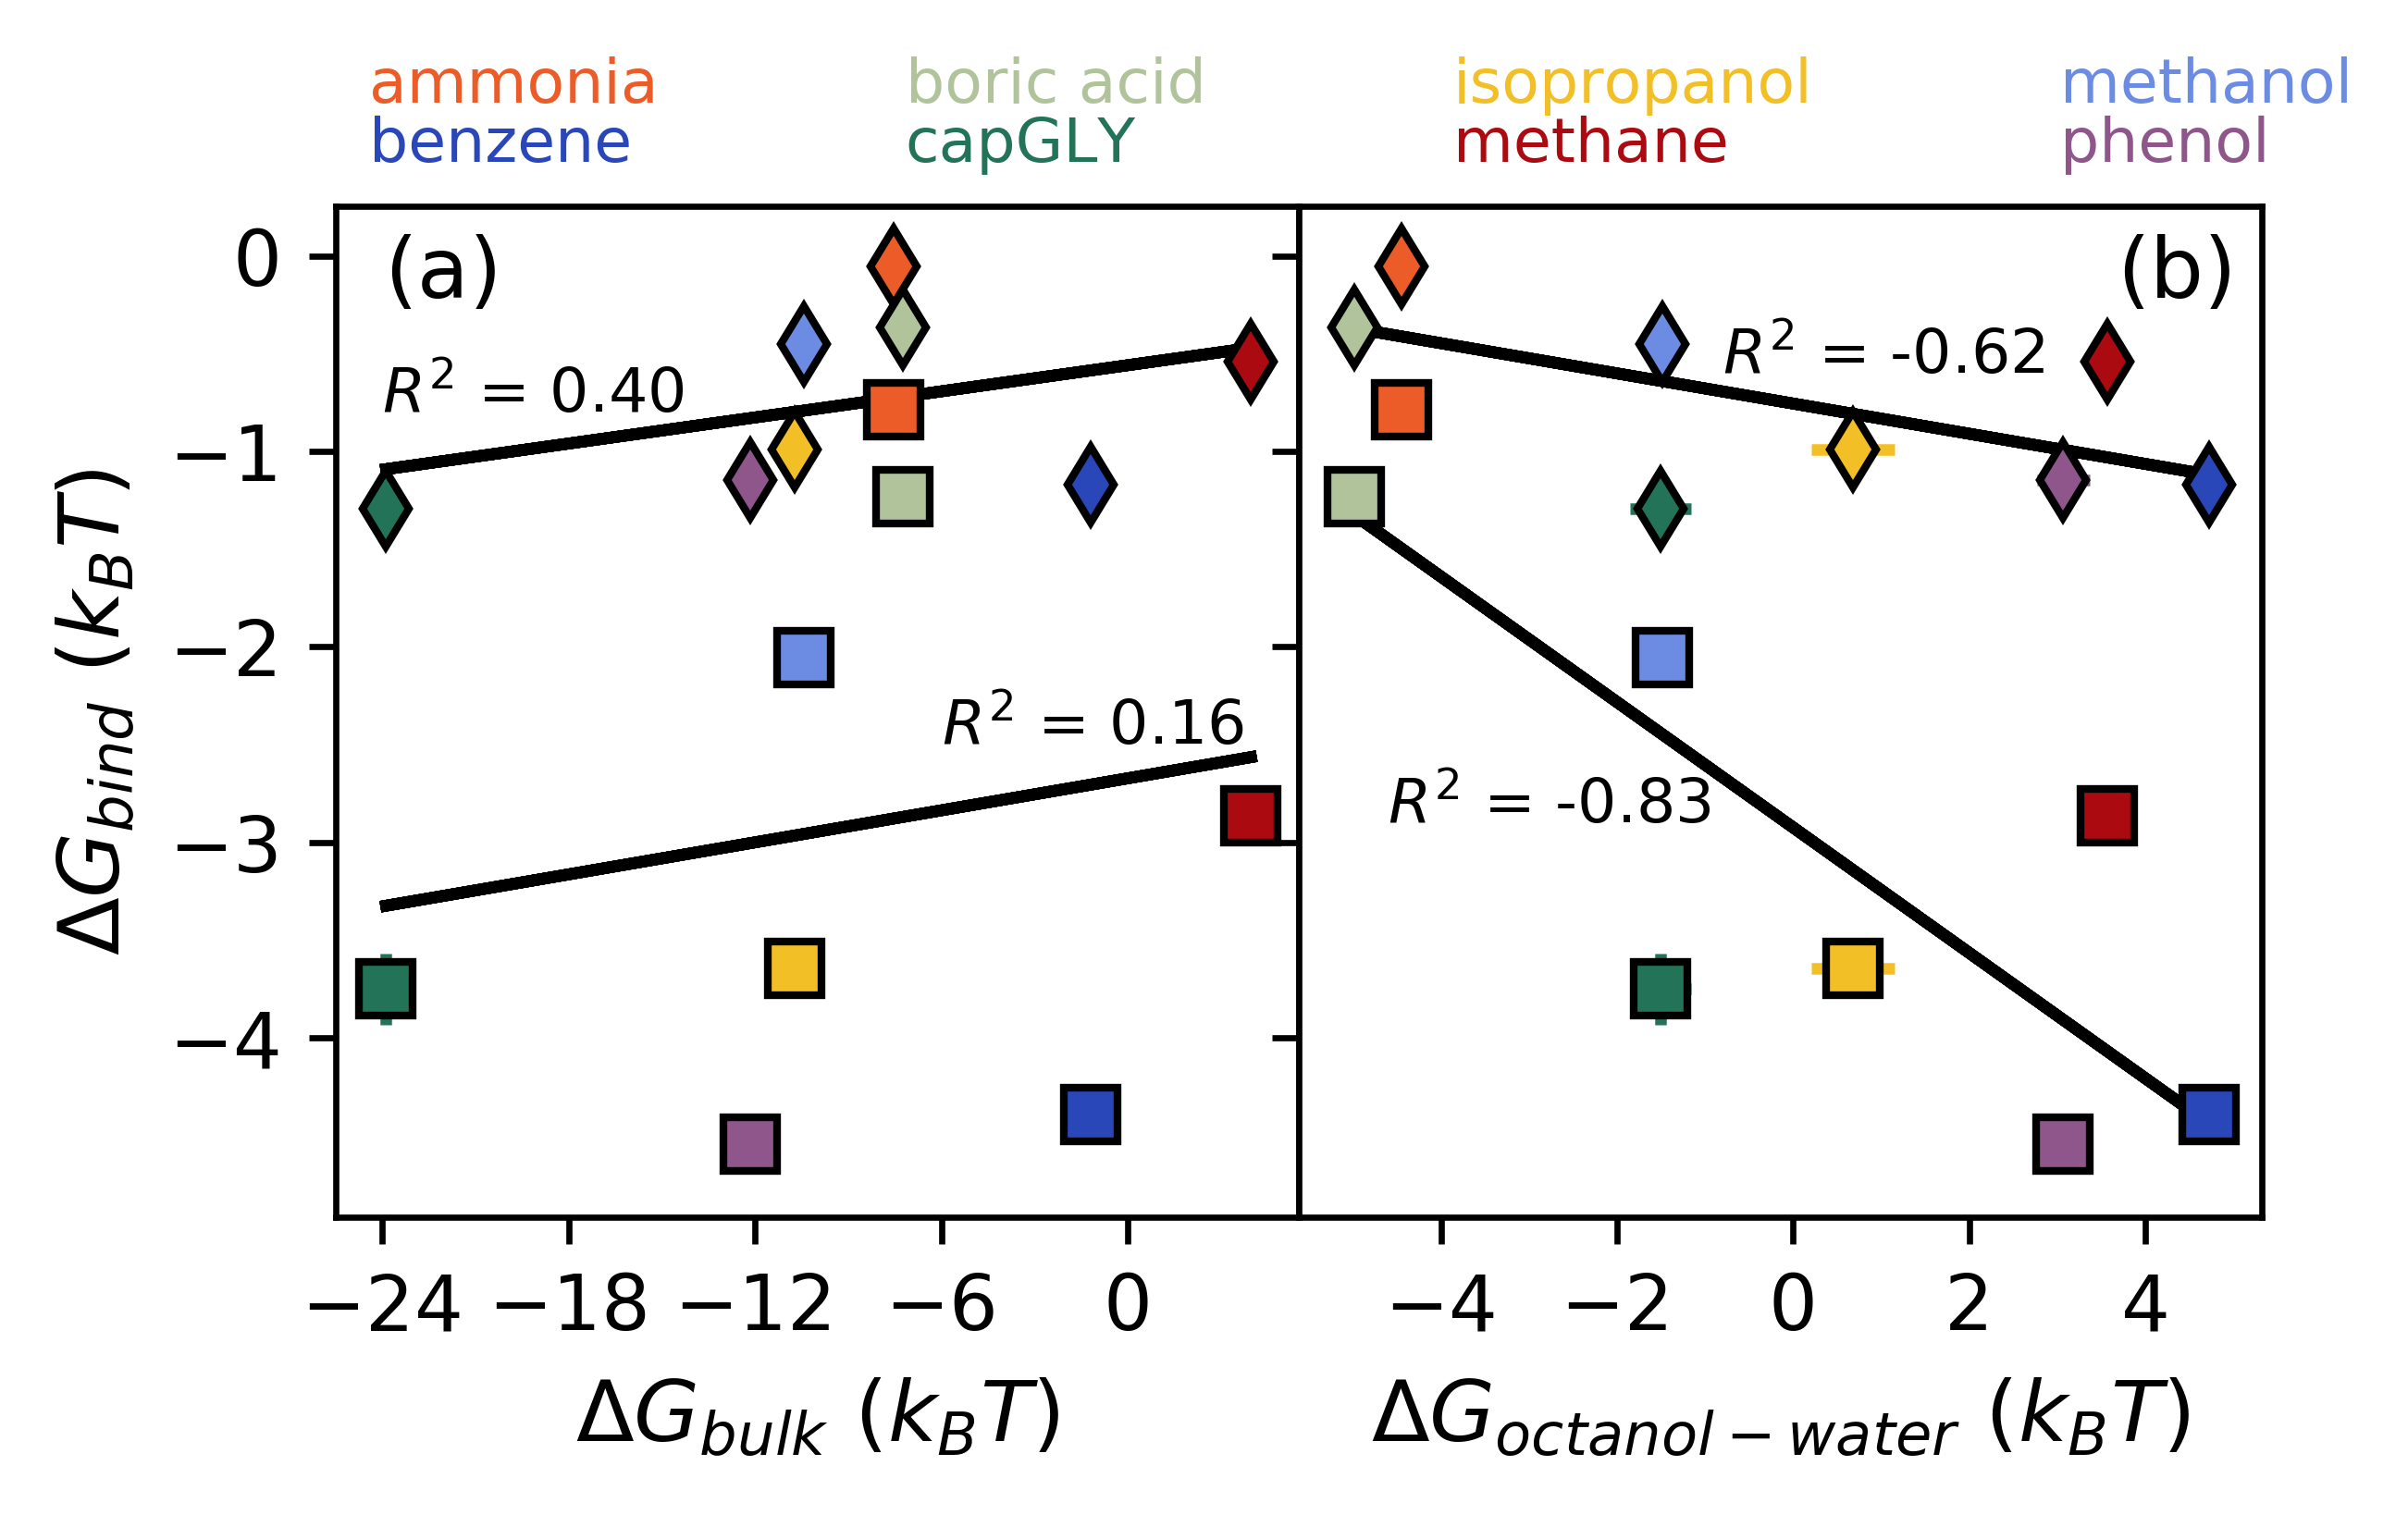

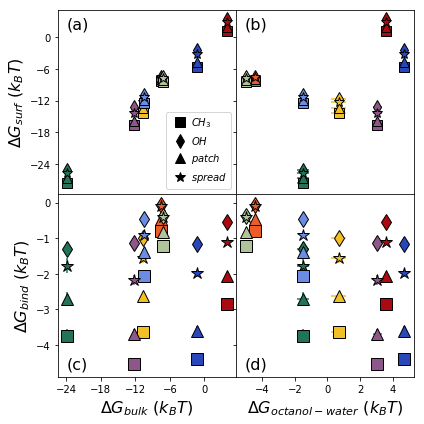

In [31]:
#Ready to generate figures - doing main text figures in order, with SI figures as convenient
#Any SI figures not generated with the main text figures will be created at the end

#Figure 1 (and Figure S1)
#Plot differences in solvation free energies at different surfaces versus bulk solvation
#Should give sense of how much surface affinity matters for more/less hydrophilic molecules
from scipy.stats import linregress

corrFig, corrAx = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(3.54, 2.83), dpi=600)
siCorrFig, siCorrAx = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(6,6))

#For linear regression, need arrays of all solute values, not dictionaries
allBulk = np.array([bulkdGs[s][0] for s in solNames])# if s not in ['ammonia', 'boricacid']])
allOct = np.array([-(octdGs[s][0] - bulkdGs[s][0]) for s in solNames])# if s not in ['ammonia', 'boricacid']])

#And store R^2 values for annotations
R2vals = np.zeros((2,len(surfTypes)))

for i, sol in enumerate(solNames):
    
    #print(sol)
    
    #Get bulk free energy of solvation
    thisBulk = bulkdGs[sol][0]
    thisBulkErr = bulkdGs[sol][1]
    
    #Get transfer free energy from octanol to water
    thisOct = -(octdGs[sol][0] - thisBulk)
    thisOctErr = np.sqrt(octdGs[sol][1]**2 + thisBulkErr**2) / np.sqrt(5.0)
    
    for j, surf in enumerate(surfTypes):
        thisAff = surfdGs['%s_%s'%(sol, surf)][0] - thisBulk
        thisAffErr = np.sqrt(surfdGs['%s_%s'%(sol, surf)][1]**2 + thisBulkErr**2) / np.sqrt(5.0)
        
        #For linear regression need all of them
        #To plot do separately to have different colors
        allAff = np.array([surfdGs['%s_%s'%(s, surf)][0] - bulkdGs[s][0] for s in solNames])# if s not in ['ammonia', 'boricacid']])
        linStatsBulk = linregress(allBulk, allAff)
        #print('\t%s bulk/bind R^2: %f'%(surf, linStatsBulk[2]))
        R2vals[0,j] = linStatsBulk[2]
        linStatsOct = linregress(allOct, allAff)
        #print('\t%s oct-water/bind R^2: %f'%(surf, linStatsOct[2]))
        R2vals[1,j] = linStatsOct[2]
        
        siCorrAx[0,0].errorbar(thisBulk, surfdGs['%s_%s'%(sol, surf)][0], 
                               xerr=thisBulkErr, yerr=surfdGs['%s_%s'%(sol, surf)][1], 
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=10, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
        siCorrAx[0,1].errorbar(thisOct, surfdGs['%s_%s'%(sol, surf)][0],
                               xerr=thisOctErr, yerr=surfdGs['%s_%s'%(sol, surf)][1],
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=10, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
        siCorrAx[1,0].errorbar(thisBulk, thisAff, xerr=thisBulkErr, yerr=thisAffErr, 
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=12, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
        siCorrAx[1,1].errorbar(thisOct, thisAff, xerr=thisOctErr, yerr=thisAffErr, 
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=12, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
        
        if surf in ['fullCH3', 'fullOH']:
            corrAx[0].errorbar(thisBulk, thisAff, xerr=thisBulkErr, yerr=thisAffErr,
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=7, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
            minmaxBulk = np.array([np.min(allBulk), np.max(allBulk)])
            corrAx[0].plot(minmaxBulk, linStatsBulk[0]*minmaxBulk+linStatsBulk[1], 'k')
            
            corrAx[1].errorbar(thisOct, thisAff, xerr=thisOctErr, yerr=thisAffErr,
                               fmt=surfMarkers[j], markerfacecolor=solColors[i], markeredgecolor='k', markersize=7, 
                               ecolor=solColors[i], elinewidth=1.5, capthick=2.0)
            minmaxOct = np.array([np.min(allOct), np.max(allOct)])
            corrAx[1].plot(minmaxOct, linStatsOct[0]*minmaxOct+linStatsOct[1], 'k')

print(R2vals)

for ax in corrAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))
    ax.tick_params(axis='both', labelsize=10)

corrAx[0].set_ylabel(r'$\Delta G_{bind}$ ($k_{B}T$)', fontsize=11)
corrAx[0].set_xlabel(r'$\Delta G_{bulk}$ ($k_{B}T$)', fontsize=11)
corrAx[1].set_xlabel(r'$\Delta G_{octanol-water}$ ($k_{B}T$)', fontsize=11)

corrAx[0].annotate('(a)', xy=(0.05, 0.91), xycoords='axes fraction', fontsize=11)
corrAx[1].annotate('(b)', xy=(0.85, 0.91), xycoords='axes fraction', fontsize=11)

corrAx[0].annotate(r'$R^2$ = %1.2f'%R2vals[0,0], xy=(-6.0, -2.5), xycoords='data', fontsize=8)
corrAx[0].annotate(r'$R^2$ = %1.2f'%R2vals[0,1], xy=(-24.0, -0.8), xycoords='data', fontsize=8)
corrAx[1].annotate(r'$R^2$ = %1.2f'%R2vals[1,0], xy=(-4.6, -2.9), xycoords='data', fontsize=8)
corrAx[1].annotate(r'$R^2$ = %1.2f'%R2vals[1,1], xy=(-0.8, -0.6), xycoords='data', fontsize=8)

legendElements = []
for x in range(len(solNames)):
    if solNames[x] == 'boricacid':
        thisName = 'boric acid'
    else:
        thisName = solNames[x]
    legendElements.append(mpl.lines.Line2D([0], [0], color=solColors[x], linestyle='None', 
                         marker='', markersize=7, label=r'%s'%thisName))
corrLeg = corrAx[0].legend(handles=legendElements, fontsize=8, frameon=False,
                           loc='lower center', bbox_to_anchor=(1.0, 1.0), ncol=4,
                           handletextpad=0.01, borderpad=0.01, labelspacing=0.01)
for i, text in enumerate(corrLeg.get_texts()):
    #text.set_color(solColors[i])
    plt.setp(text, color=solColors[i], weight='normal')
    
corrFig.tight_layout()
corrFig.subplots_adjust(wspace=0.0, left=0.01, right=0.99)

for i in range(siCorrAx.shape[0]):
    for j in range(siCorrAx.shape[1]):
        siCorrAx[i,j].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))
        siCorrAx[i,j].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))

siCorrAx[0,0].set_ylabel(r'$\Delta G_{surf}$ ($k_{B}T$)', fontsize=16)
siCorrAx[1,0].set_ylabel(r'$\Delta G_{bind}$ ($k_{B}T$)', fontsize=16)
siCorrAx[1,0].set_xlabel(r'$\Delta G_{bulk}$ ($k_{B}T$)', fontsize=16)
siCorrAx[1,1].set_xlabel(r'$\Delta G_{octanol-water}$ ($k_{B}T$)', fontsize=16)

siCorrAx[0,0].annotate('(a)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=16)
siCorrAx[0,1].annotate('(b)', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=16)
siCorrAx[1,0].annotate('(c)', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=16)
siCorrAx[1,1].annotate('(d)', xy=(0.05, 0.05), xycoords='axes fraction', fontsize=16)

siLegendElements = ([mpl.lines.Line2D([0], [0], color='k', linestyle='None', 
                                      marker=surfMarkers[x], markersize=10, label=r'$%s$'%surfLabels[x]) 
                     for x in range(len(surfTypes))])
siCorrAx[0,0].legend(handles=siLegendElements, loc=4, numpoints=1, handletextpad=0.10)

siCorrFig.tight_layout()
siCorrFig.subplots_adjust(wspace=0.0, hspace=0.0)

plt.show()


#Correlation with octanol-water transfer seems alright at -0.83, but drops to -0.53 if exclude ammonia and boric acid


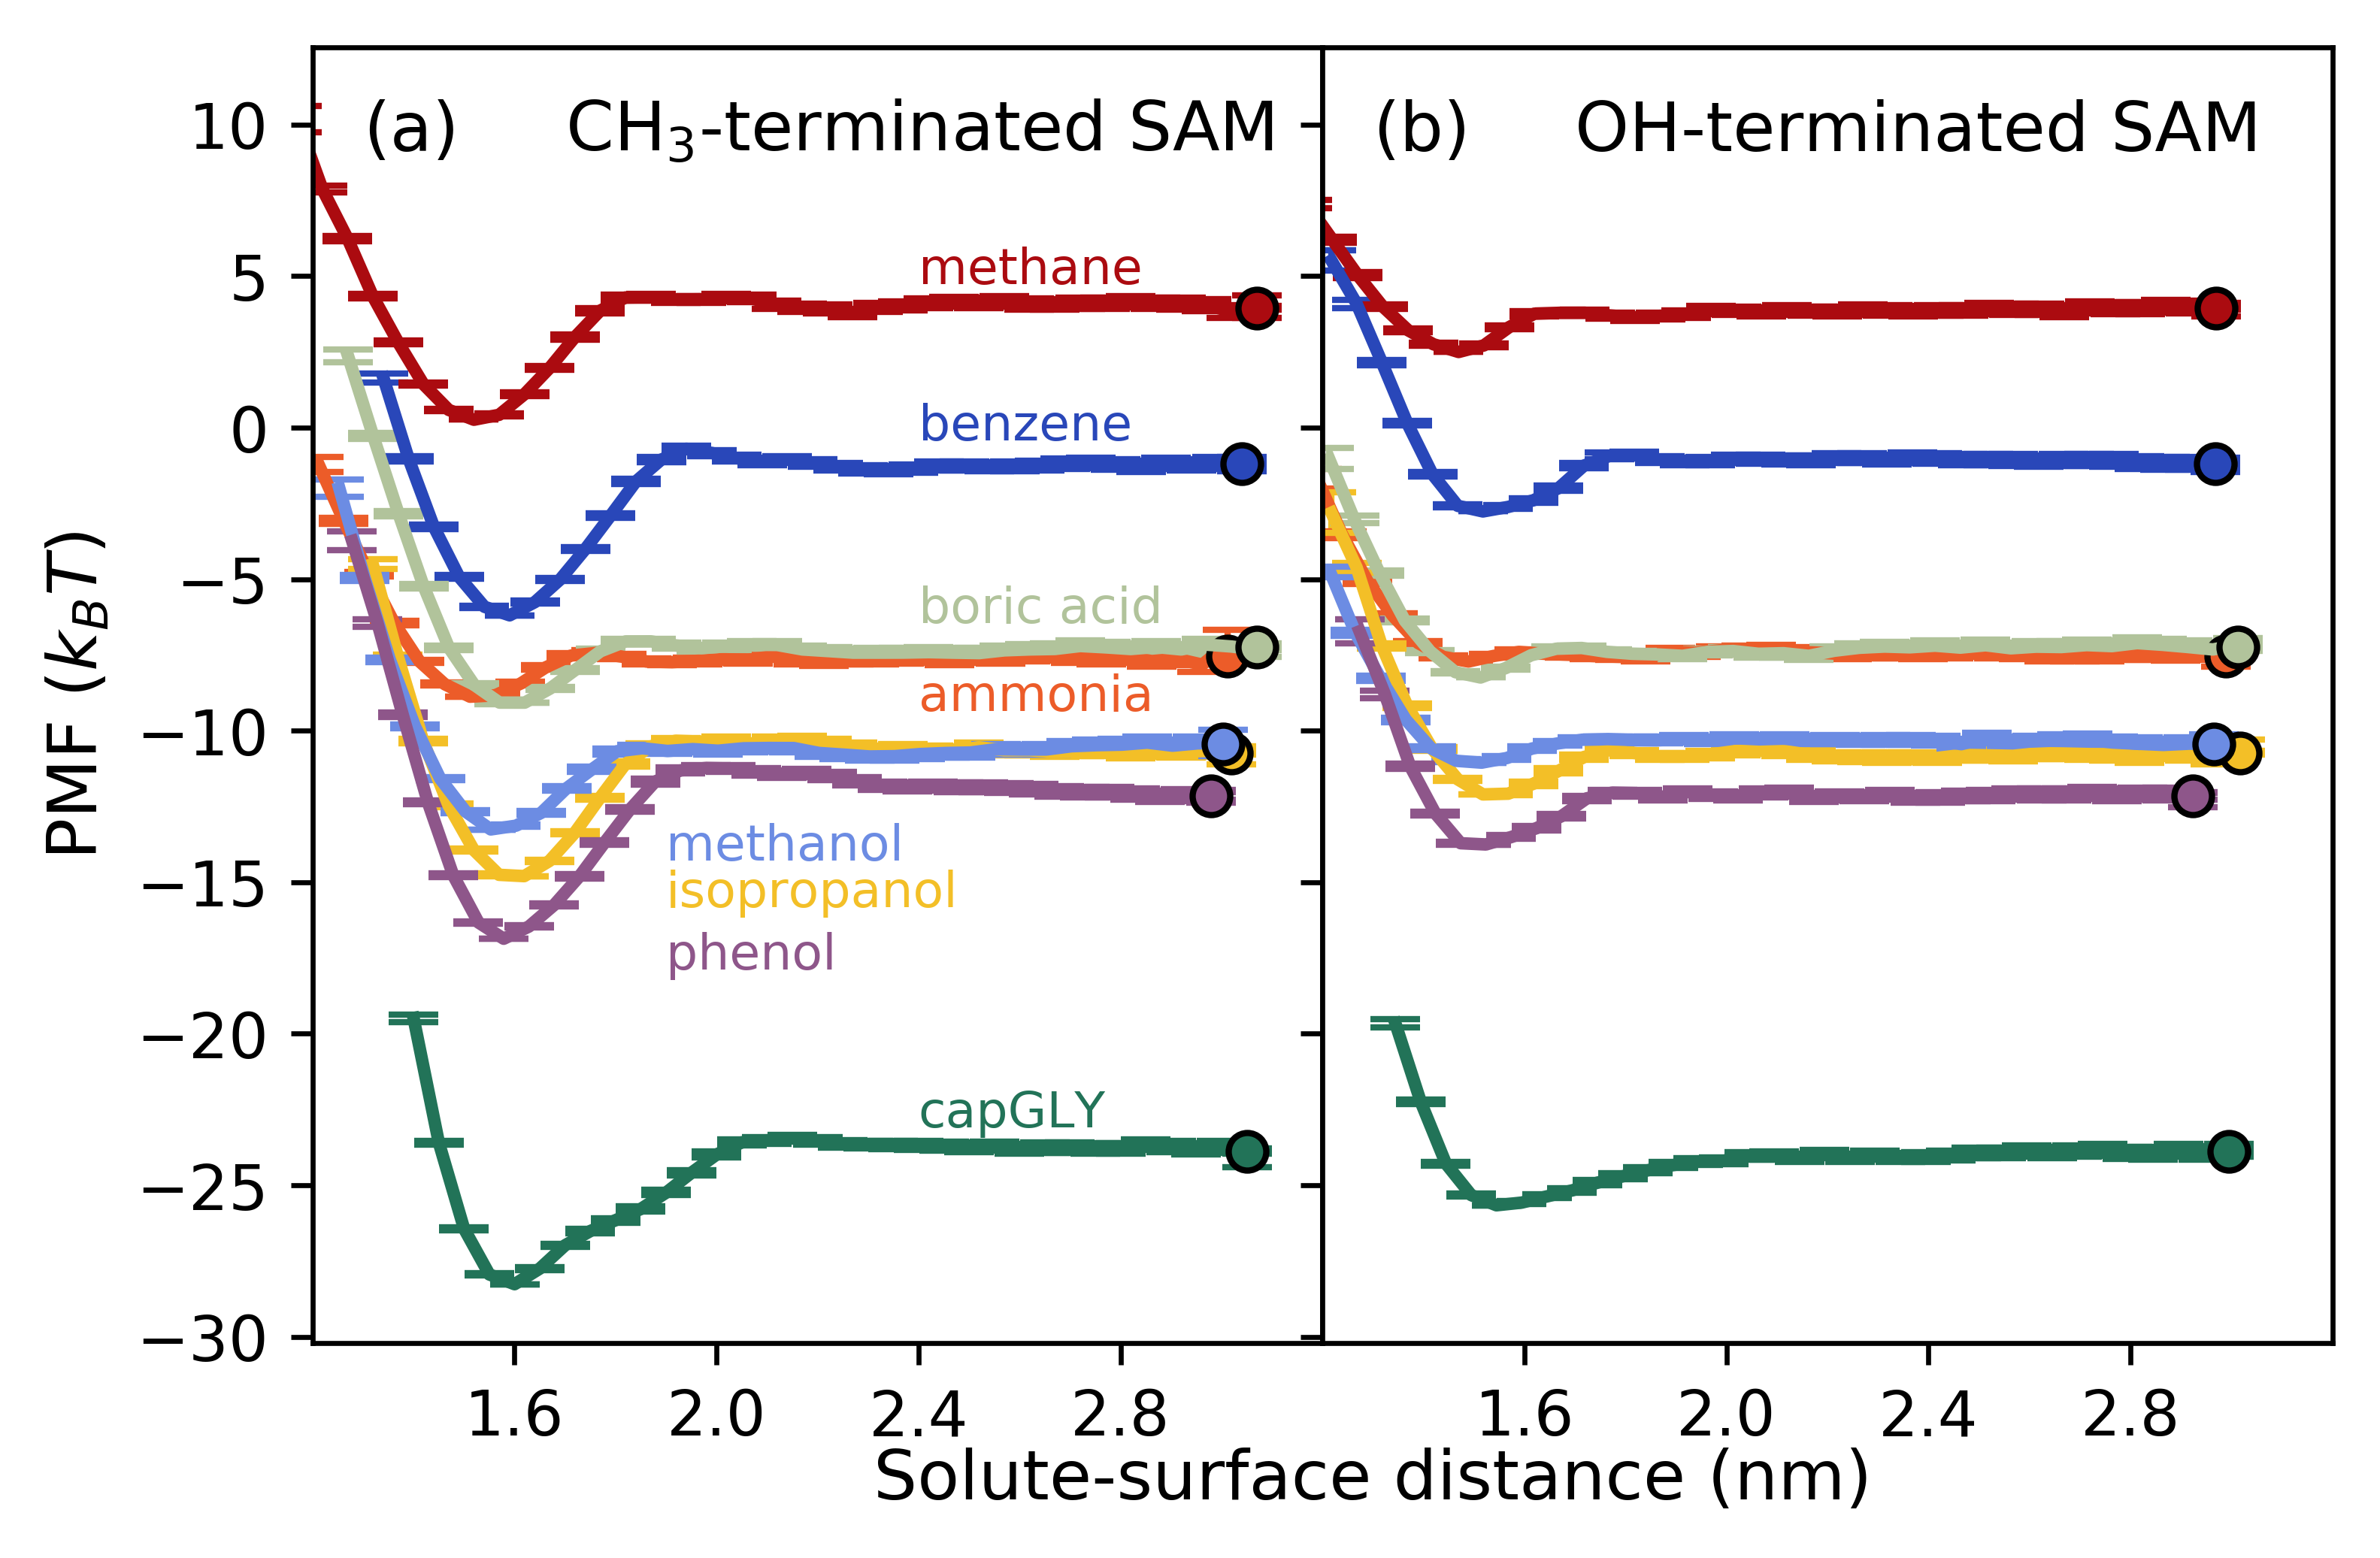

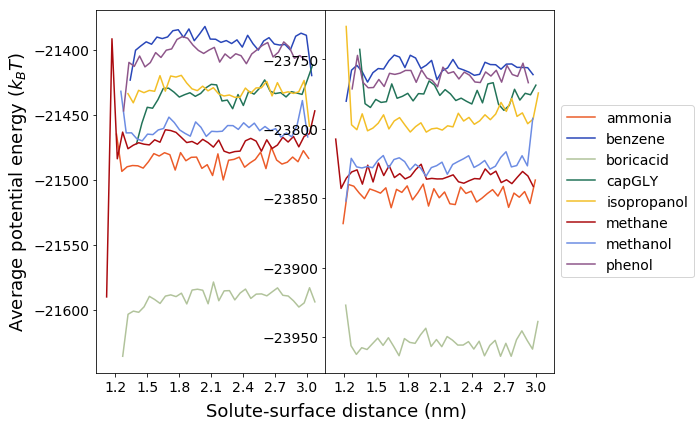

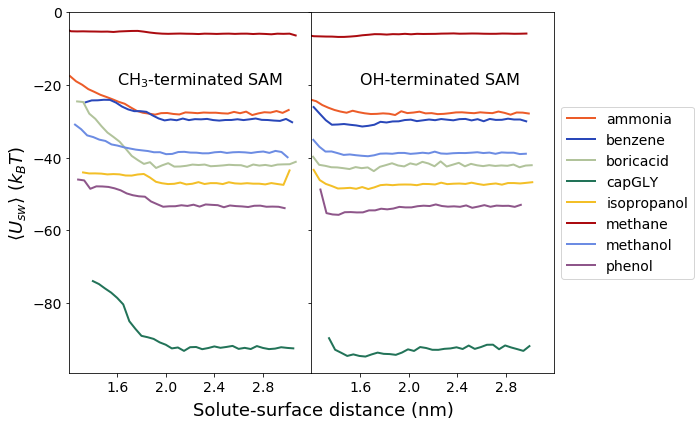

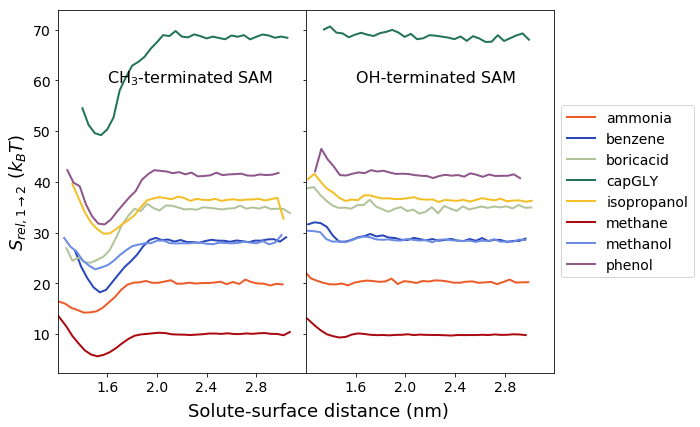

In [32]:
#Figure 2 (and PMF figures in SI)

#Now read in PMFs and plot
pmfFig, pmfAx = plt.subplots(1, len(surfTypesUmb), sharex=True, sharey=True, figsize=(4.57, 3.54), dpi=600)
pmfPotFig, pmfPotAx = plt.subplots(1, len(surfTypesUmb), sharex=True, sharey=False, figsize=(10, 6))
uSolFig, uSolAx = plt.subplots(1, len(surfTypesUmb), sharex=True, sharey=True, figsize=(10, 6))
srelFig, srelAx = plt.subplots(1, len(surfTypesUmb), sharex=True, sharey=True, figsize=(10, 6))

allPMFs = {}

for i, sol in enumerate(solNames):
    
    for j, surf in enumerate(surfTypesUmb):
        
        #Read in the PMF info and store
        thisPMF = np.loadtxt('%s/umbrella_sampling/%s/%s/pmf.txt'%(baseDir, sol, surf))
        allPMFs['%s_%s'%(sol, surf)] = thisPMF
        
        #Want to shift each curve so it ends in bulk at its bulk solvation free energy
        toplot = thisPMF[:,1]
        toplot -= np.average(toplot[-3:])
        toplot += bulkdGs[sol][0]
        
        #And plot PMF
        pmfAx[j].errorbar(thisPMF[:,0], toplot, yerr=thisPMF[:,2], label=sol,
                          color=solColors[i], ecolor=solColors[i], linewidth=2, elinewidth=1, capsize=4)
        
        #Also plot the bulk solvation data point as far from the PMF as possible
        pmfAx[j].errorbar(thisPMF[-1,0], bulkdGs[sol][0], yerr=bulkdGs[sol][1]/np.sqrt(5.0), 
                          marker='o', markerfacecolor=solColors[i], markeredgecolor='k',
                          ecolor=solColors[i], elinewidth=1, capsize=4)
        
        if surf == 'fullCH3':
            if sol in ['methane', 'benzene', 'boricacid', 'capGLY']:
                if sol == 'boricacid':
                    this_sol = 'boric acid'
                else:
                    this_sol = sol
                pmfAx[j].annotate('%s'%this_sol, xy=(2.4, bulkdGs[sol][0] + 0.8), xycoords='data', 
                                  color=solColors[i], fontsize=8)
            elif sol in ['ammonia']:
                pmfAx[j].annotate('%s'%sol, xy=(2.4, bulkdGs[sol][0] - 1.8), xycoords='data', 
                                  color=solColors[i], fontsize=8)
            elif sol in ['isopropanol', 'methanol', 'phenol']:
                pmfAx[j].annotate('%s'%sol, xy=(1.9, np.min(toplot) - 1.0), xycoords='data',
                                  color=solColors[i], fontsize=8)
        
        #Also plot average potential energy as a function of distance from the interface (~enthalphy)
        thisPMFpot = np.loadtxt('%s/umbrella_sampling/%s/%s/pmf_U.txt'%(baseDir, sol, surf))
        pmfPotAx[j].plot(thisPMFpot[:,0], thisPMFpot[:,1], label=sol, color=solColors[i])
        
        #Decompose PMFs into contributions from solute-system potential energy and relative entropy of solvation
        uSolAx[j].plot(thisPMFpot[:,0], thisPMFpot[:,2], label=sol,
                       color=solColors[i], linewidth=2)
        srelAx[j].plot(thisPMF[:,0], toplot - thisPMFpot[:,2], label=sol,
                       color=solColors[i], linewidth=2)

for ax in pmfAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='both'))
    ax.tick_params(axis='both', labelsize=10)
    
for ax in uSolAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='both'))
    ax.tick_params(axis='both', labelsize=14)
    
for ax in srelAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='both'))
    ax.tick_params(axis='both', labelsize=14)

pmfAx[0].xaxis.set_label_coords(1.05, -0.08)
pmfAx[0].set_xlabel(r'Solute-surface distance (nm)', fontsize=11)
pmfAx[0].set_ylabel(r'PMF ($k_{B}T$)', fontsize=11)

#pmfAx[0].set_ylim([-30, 9])
pmfAx[0].set_xlim([1.2, 3.2])

#pmfAx[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

pmfAx[0].annotate(r'CH$_{3}$-terminated SAM', xy=(0.25, 0.92), xycoords='axes fraction', fontsize=11)
pmfAx[1].annotate(r'OH-terminated SAM', xy=(0.25, 0.92), xycoords='axes fraction', fontsize=11)

pmfAx[0].annotate(r'(a)', xy=(0.05, 0.92), xycoords='axes fraction', fontsize=11)
pmfAx[1].annotate(r'(b)', xy=(0.05, 0.92), xycoords='axes fraction', fontsize=11)

pmfFig.tight_layout()
pmfFig.subplots_adjust(wspace=0, left=0.01, right=0.99)

uSolAx[0].xaxis.set_label_coords(1.05, -0.08)
uSolAx[0].set_xlabel(r'Solute-surface distance (nm)', fontsize=18)
uSolAx[0].set_ylabel(r'$\langle U_{sw} \rangle$ ($k_{B}T$)', fontsize=18)

#uSolAx[0].set_ylim([-30, 9])
uSolAx[0].set_xlim([1.2, 3.2])

uSolAx[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

uSolAx[0].annotate(r'CH$_{3}$-terminated SAM', xy=(0.2, 0.80), xycoords='axes fraction', fontsize=16)
uSolAx[1].annotate(r'OH-terminated SAM', xy=(0.2, 0.80), xycoords='axes fraction', fontsize=16)

uSolFig.tight_layout()
uSolFig.subplots_adjust(wspace=0, right=0.775)

srelAx[0].xaxis.set_label_coords(1.05, -0.08)
srelAx[0].set_xlabel(r'Solute-surface distance (nm)', fontsize=18)
srelAx[0].set_ylabel(r'$S_{rel,1 \rightarrow 2}$ ($k_{B}T$)', fontsize=18)

#srelAx[0].set_ylim([-30, 9])
srelAx[0].set_xlim([1.2, 3.2])

srelAx[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

srelAx[0].annotate(r'CH$_{3}$-terminated SAM', xy=(0.2, 0.80), xycoords='axes fraction', fontsize=16)
srelAx[1].annotate(r'OH-terminated SAM', xy=(0.2, 0.80), xycoords='axes fraction', fontsize=16)

srelFig.tight_layout()
srelFig.subplots_adjust(wspace=0, right=0.775)

for ax in pmfPotAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, prune='both'))
    ax.tick_params(axis='both', labelsize=14)

pmfPotAx[0].xaxis.set_label_coords(1.05, -0.08)
pmfPotAx[0].set_xlabel(r'Solute-surface distance (nm)', fontsize=18)
pmfPotAx[0].set_ylabel(r'Average potential energy ($k_{B}T$)', fontsize=18)

pmfPotAx[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
pmfPotFig.tight_layout()
pmfPotFig.subplots_adjust(wspace=0, right=0.775)

plt.show()


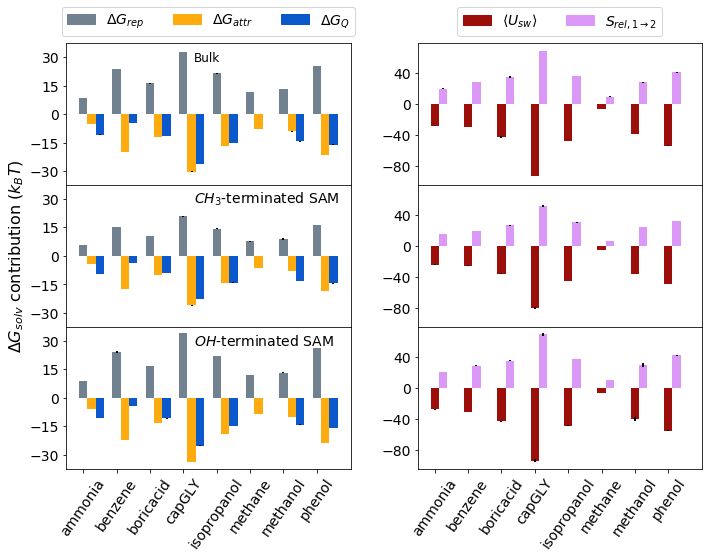

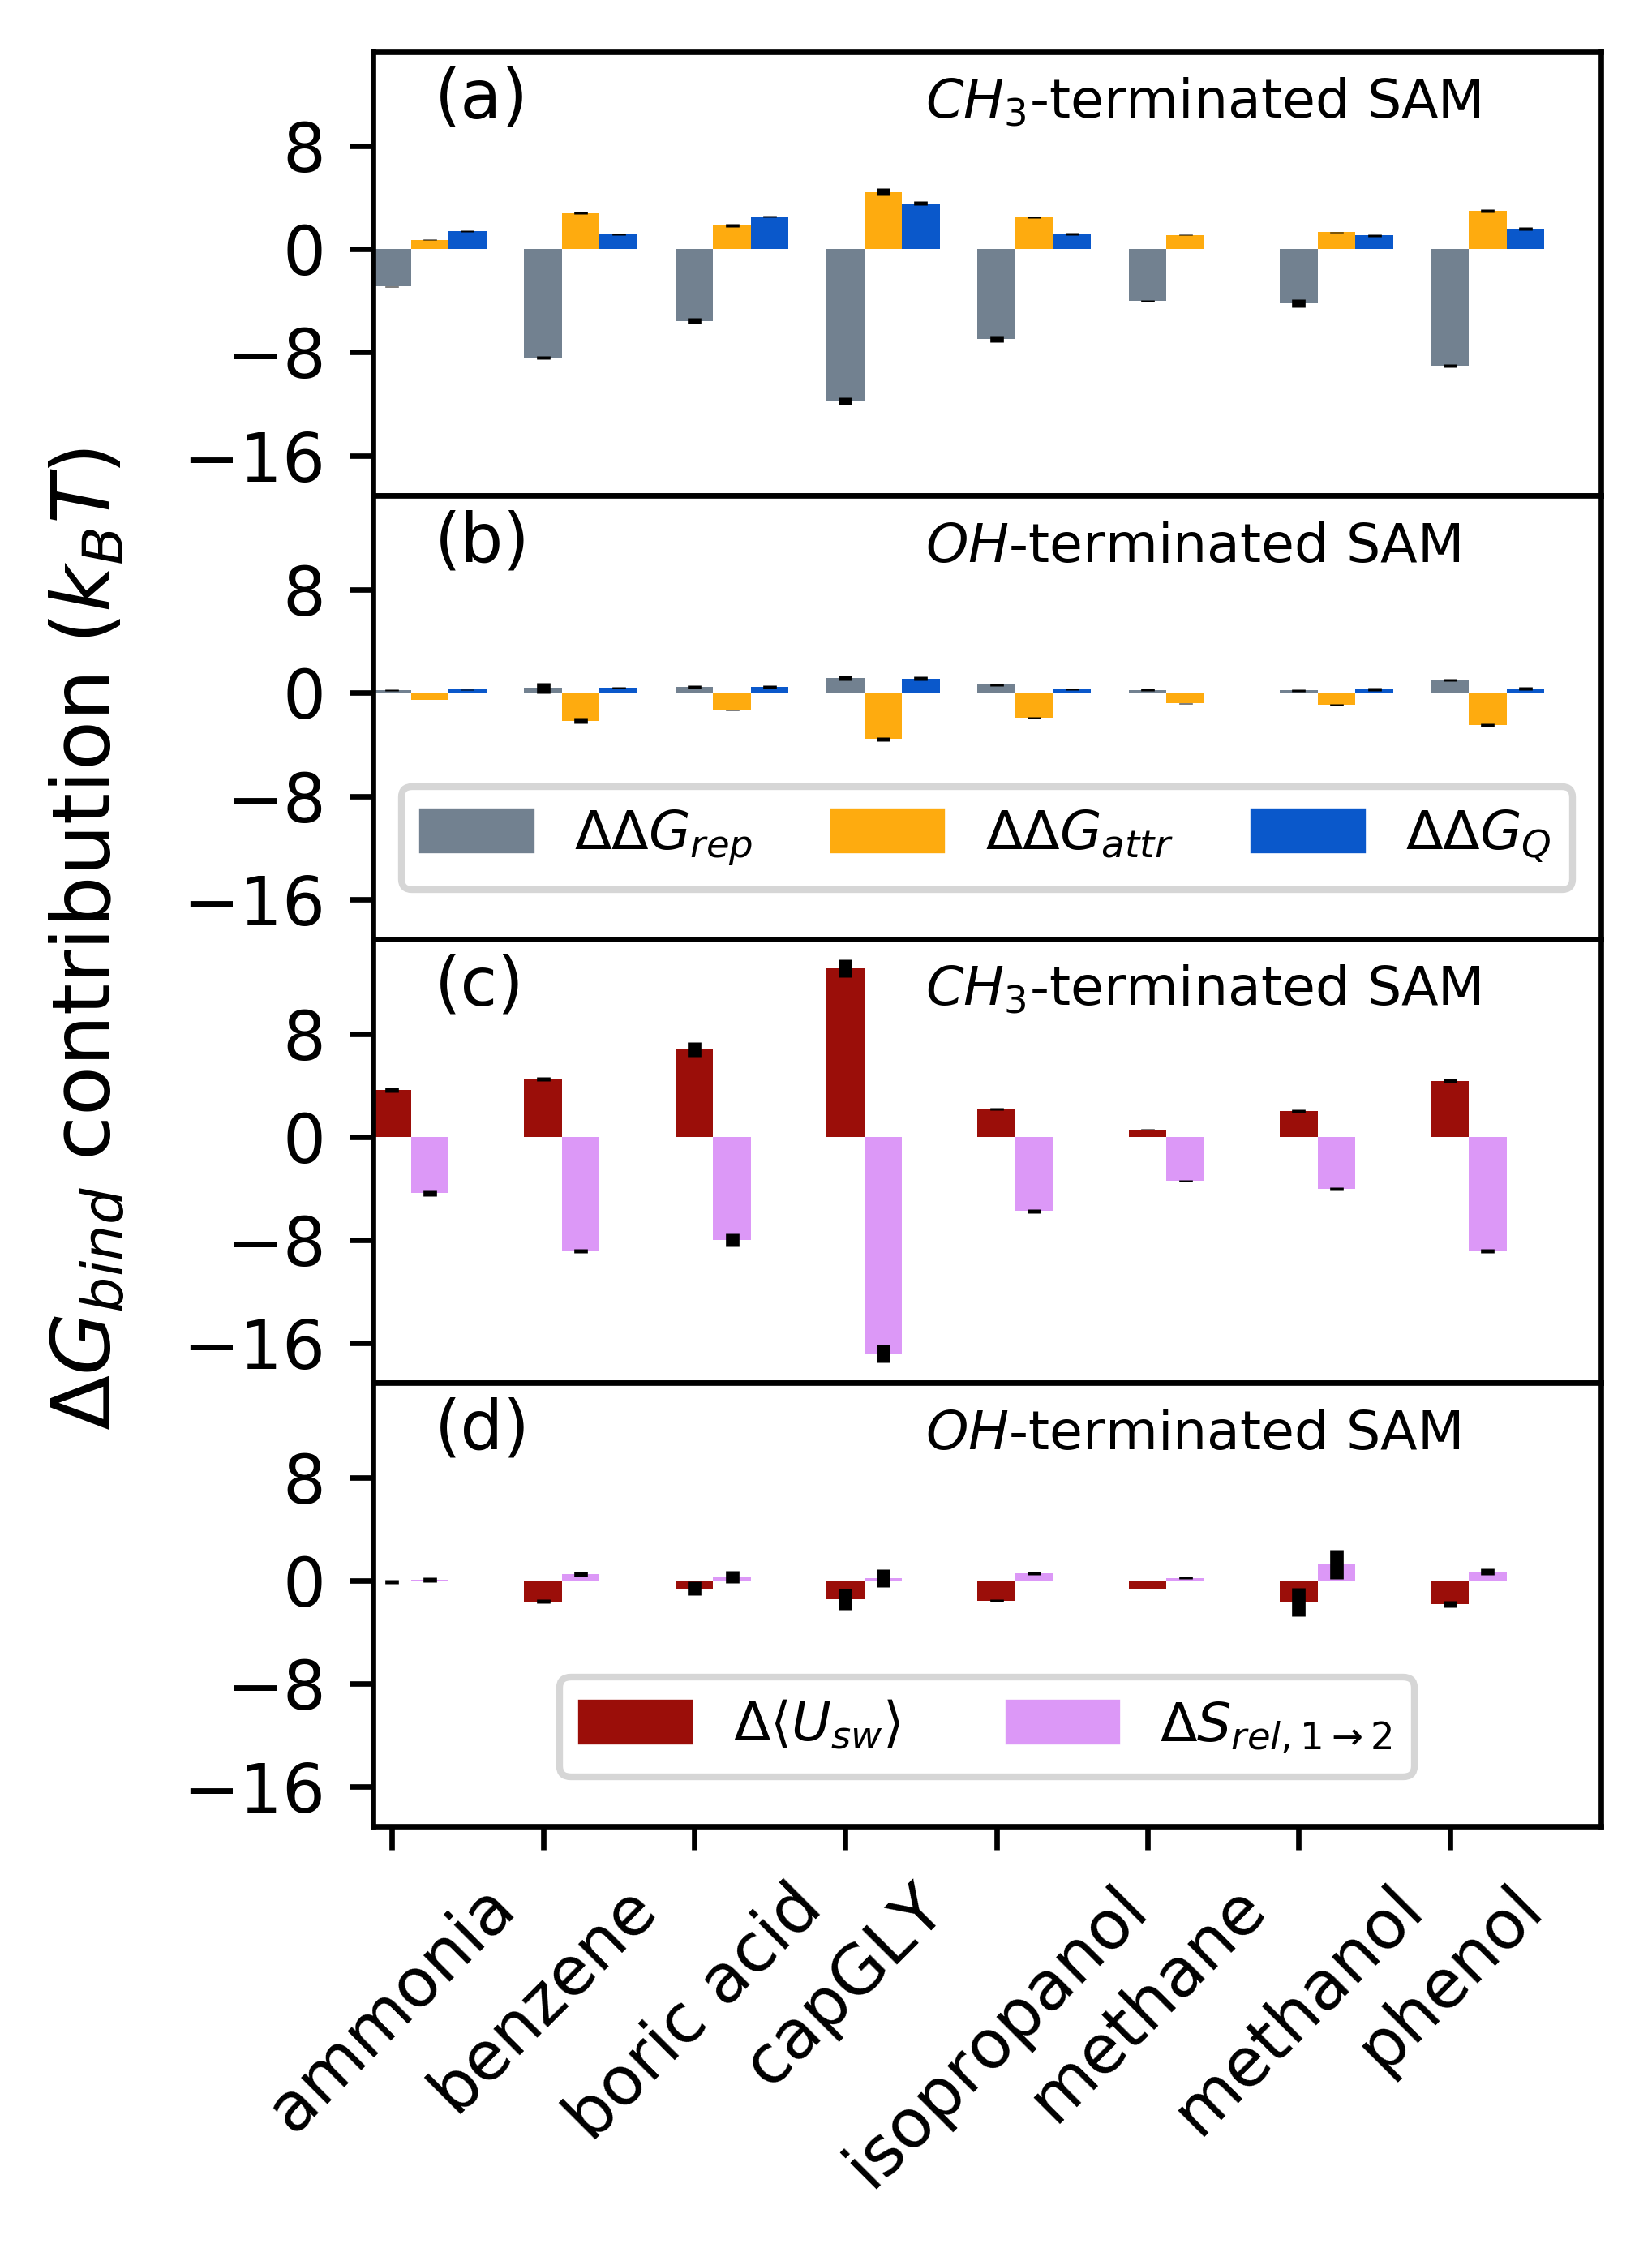

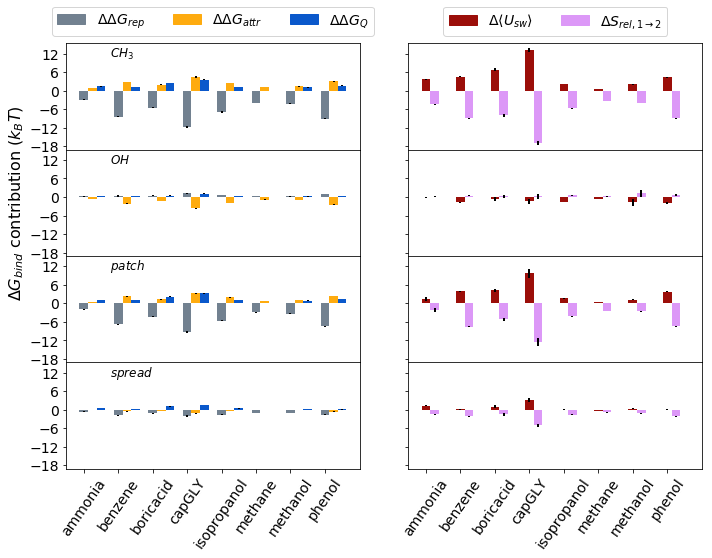

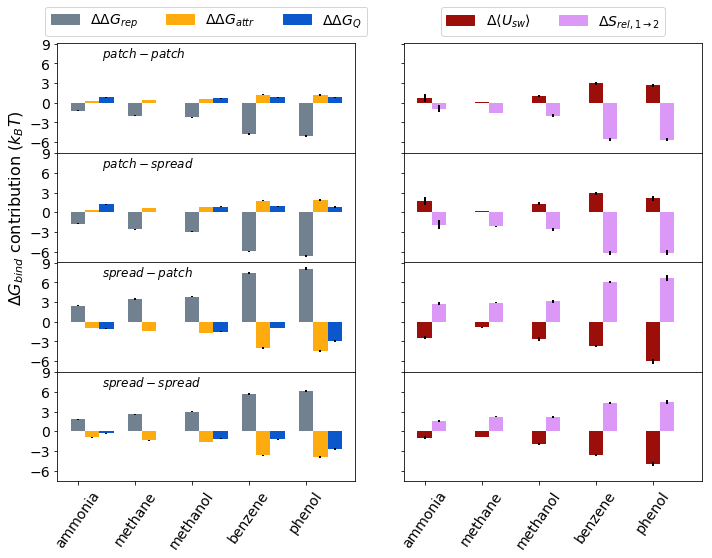

In [38]:
#Figure 3 (and some SI figures)

#Now that we've run a bunch of analysis, realized that it's insightful to break down solvation free energy contributions
#Want to create (stacked?) bar charts for electrostatic, LJ (attractive and HS) contributions to the free energy

solvFig, solvAx = plt.subplots(3, 2, sharex=True, sharey='col', figsize=(10,8))
affBarFig, affBarAx = plt.subplots(4, sharex=True, sharey=True, figsize=(3.54, 4.72), dpi=600)
allBarFig, allBarAx = plt.subplots(len(surfTypes), 2, sharex=True, sharey=True, figsize=(10,8))
chargeBarFig, chargeBarAx = plt.subplots(len(chargeSurfTypes), 2, sharex=True, sharey=True, figsize=(10,8))

barwidth = 0.25

compColors = ['#0a58cb', '#728190', '#feab0f']
srelColors = ['#9b0e09', '#dc98f7']

for i, sol in enumerate(solNames):
    
    #Plot breakdown of bulk solvation free energies
    solvAx[0,0].bar(i, bulkdGwca[sol][0], barwidth, yerr=bulkdGwca[sol][1]/np.sqrt(5.0), 
                    facecolor=compColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
    solvAx[0,0].bar(i+barwidth, bulkdGattr[sol][0], barwidth, yerr=bulkdGattr[sol][1]/np.sqrt(5.0), 
                    facecolor=compColors[2], error_kw=dict(ecolor='black', lw=2, capthick=1))
    solvAx[0,0].bar(i+2*barwidth, bulkdGq[sol][0], barwidth, yerr=bulkdGq[sol][1]/np.sqrt(5.0), 
                    facecolor=compColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
    
    #Breakdown in terms of Srel, too
    solvAx[0,1].bar(i, bulkAvgU[sol][0], barwidth, yerr=bulkAvgU[sol][1], 
                    facecolor=srelColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
    solvAx[0,1].bar(i+barwidth, bulkSrel[sol][0], barwidth, yerr=bulkSrel[sol][1], 
                    facecolor=srelColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
    
    for j, surf in enumerate(surfTypes):
        
        #Also plot breakdown for affinites
        allBarAx[j,0].bar(i, surfdGwca["%s_%s"%(sol, surf)][0] - bulkdGwca[sol][0], barwidth, 
                          yerr=np.sqrt(surfdGwca["%s_%s"%(sol, surf)][1]**2 + bulkdGwca[sol][1]**2)/np.sqrt(5.0), 
                          facecolor=compColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
        allBarAx[j,0].bar(i+barwidth, surfdGattr["%s_%s"%(sol, surf)][0] - bulkdGattr[sol][0], barwidth, 
                          yerr=np.sqrt(surfdGattr["%s_%s"%(sol, surf)][1]**2 + bulkdGattr[sol][1]**2)/np.sqrt(5.0), 
                          facecolor=compColors[2], error_kw=dict(ecolor='black', lw=2, capthick=1))
        allBarAx[j,0].bar(i+2*barwidth, surfdGq["%s_%s"%(sol, surf)][0] - bulkdGq[sol][0], barwidth, 
                          yerr=np.sqrt(surfdGq["%s_%s"%(sol, surf)][1]**2 + bulkdGq[sol][1]**2)/np.sqrt(5.0), 
                          facecolor=compColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            
        #And in terms of Srel
        allBarAx[j,1].bar(i, surfAvgU["%s_%s"%(sol, surf)][0] - bulkAvgU[sol][0], barwidth, 
                          yerr=np.sqrt(surfAvgU["%s_%s"%(sol, surf)][1]**2 + bulkAvgU[sol][1]**2)/np.sqrt(5.0), 
                          facecolor=srelColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
        allBarAx[j,1].bar(i+barwidth, surfSrel["%s_%s"%(sol, surf)][0] - bulkSrel[sol][0], barwidth, 
                          yerr=np.sqrt(surfSrel["%s_%s"%(sol, surf)][1]**2 + bulkSrel[sol][1]**2)/np.sqrt(5.0), 
                          facecolor=srelColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
        
        if surf in ['fullCH3', 'fullOH']:
            #Plot breakdown of surface solvation free energies
            solvAx[j+1,0].bar(i, surfdGwca["%s_%s"%(sol, surf)][0], barwidth, 
                              yerr=surfdGwca["%s_%s"%(sol, surf)][1]/np.sqrt(5.0), 
                              facecolor=compColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
            solvAx[j+1,0].bar(i+barwidth, surfdGattr["%s_%s"%(sol, surf)][0], barwidth, 
                              yerr=surfdGattr["%s_%s"%(sol, surf)][1]/np.sqrt(5.0), 
                              facecolor=compColors[2], error_kw=dict(ecolor='black', lw=2, capthick=1))
            solvAx[j+1,0].bar(i+2*barwidth, surfdGq["%s_%s"%(sol, surf)][0], barwidth, 
                              yerr=surfdGq["%s_%s"%(sol, surf)][1]/np.sqrt(5.0), 
                              facecolor=compColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
        
            #Breakdown in terms of Srel, too
            solvAx[j+1,1].bar(i, surfAvgU["%s_%s"%(sol, surf)][0], barwidth, 
                              yerr=surfAvgU["%s_%s"%(sol, surf)][1], 
                              facecolor=srelColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            solvAx[j+1,1].bar(i+barwidth, surfSrel["%s_%s"%(sol, surf)][0], barwidth, 
                              yerr=surfSrel["%s_%s"%(sol, surf)][1], 
                              facecolor=srelColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
        
            #Also plot breakdown for affinites
            affBarAx[j].bar(i, surfdGwca["%s_%s"%(sol, surf)][0] - bulkdGwca[sol][0], barwidth, 
                            yerr=np.sqrt(surfdGwca["%s_%s"%(sol, surf)][1]**2 + bulkdGwca[sol][1]**2)/np.sqrt(5.0), 
                            facecolor=compColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
            affBarAx[j].bar(i+barwidth, surfdGattr["%s_%s"%(sol, surf)][0] - bulkdGattr[sol][0], barwidth, 
                            yerr=np.sqrt(surfdGattr["%s_%s"%(sol, surf)][1]**2 + bulkdGattr[sol][1]**2)/np.sqrt(5.0), 
                            facecolor=compColors[2], error_kw=dict(ecolor='black', lw=2, capthick=1))
            affBarAx[j].bar(i+2*barwidth, surfdGq["%s_%s"%(sol, surf)][0] - bulkdGq[sol][0], barwidth, 
                            yerr=np.sqrt(surfdGq["%s_%s"%(sol, surf)][1]**2 + bulkdGq[sol][1]**2)/np.sqrt(5.0), 
                            facecolor=compColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            
            #And in terms of Srel
            affBarAx[j+2].bar(i, surfAvgU["%s_%s"%(sol, surf)][0] - bulkAvgU[sol][0], barwidth, 
                              yerr=np.sqrt(surfAvgU["%s_%s"%(sol, surf)][1]**2 + bulkAvgU[sol][1]**2)/np.sqrt(5.0), 
                              facecolor=srelColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            affBarAx[j+2].bar(i+barwidth, surfSrel["%s_%s"%(sol, surf)][0] - bulkSrel[sol][0], barwidth, 
                              yerr=np.sqrt(surfSrel["%s_%s"%(sol, surf)][1]**2 + bulkSrel[sol][1]**2)/np.sqrt(5.0), 
                              facecolor=srelColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))


for i, sol in enumerate(chargeSolNames):
        for j, surf in enumerate(chargeSurfTypes):
            #Also plot breakdown for affinites
            chargeBarAx[j,0].bar(i, chargedGwca["%s_%s"%(sol, surf)][0] - bulkdGwca[sol][0], barwidth, 
                                 yerr=np.sqrt(chargedGwca["%s_%s"%(sol, surf)][1]**2 + bulkdGwca[sol][1]**2)/np.sqrt(5.0), 
                                 facecolor=compColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))
            chargeBarAx[j,0].bar(i+barwidth, chargedGattr["%s_%s"%(sol, surf)][0] - bulkdGattr[sol][0], barwidth, 
                                 yerr=np.sqrt(chargedGattr["%s_%s"%(sol, surf)][1]**2 + bulkdGattr[sol][1]**2)/np.sqrt(5.0), 
                                 facecolor=compColors[2], error_kw=dict(ecolor='black', lw=2, capthick=1))
            chargeBarAx[j,0].bar(i+2*barwidth, chargedGq["%s_%s"%(sol, surf)][0] - bulkdGq[sol][0], barwidth, 
                                 yerr=np.sqrt(chargedGq["%s_%s"%(sol, surf)][1]**2 + bulkdGq[sol][1]**2)/np.sqrt(5.0), 
                                 facecolor=compColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            
            #And in terms of Srel
            chargeBarAx[j,1].bar(i, chargeAvgU["%s_%s"%(sol, surf)][0] - bulkAvgU[sol][0], barwidth, 
                                 yerr=np.sqrt(chargeAvgU["%s_%s"%(sol, surf)][1]**2 + bulkAvgU[sol][1]**2)/np.sqrt(5.0), 
                                 facecolor=srelColors[0], error_kw=dict(ecolor='black', lw=2, capthick=1))
            chargeBarAx[j,1].bar(i+barwidth, chargeSrel["%s_%s"%(sol, surf)][0] - bulkSrel[sol][0], barwidth, 
                                 yerr=np.sqrt(chargeSrel["%s_%s"%(sol, surf)][1]**2 + bulkSrel[sol][1]**2)/np.sqrt(5.0), 
                                 facecolor=srelColors[1], error_kw=dict(ecolor='black', lw=2, capthick=1))

legendHandlesBar = [mpl.patches.Patch(color='#728190', label='$\Delta G_{rep}$'),
                    mpl.patches.Patch(color='#feab0f', label='$\Delta G_{attr}$'),
                    mpl.patches.Patch(color='#0a58cb', label=r'$\Delta G_{Q}$')]

legendHandlesBarBind = [mpl.patches.Patch(color='#728190', label='$\Delta \Delta G_{rep}$'),
                        mpl.patches.Patch(color='#feab0f', label='$\Delta \Delta G_{attr}$'),
                        mpl.patches.Patch(color='#0a58cb', label=r'$\Delta \Delta G_{Q}$')]

legendHandlesSrel = [mpl.patches.Patch(color='#9b0e09', label=r'$\Delta \langle U_{sw} \rangle$'),
                     mpl.patches.Patch(color='#dc98f7', label=r'$\Delta S_{rel,1 \rightarrow 2}$')]

legendHandlesSrelSolv = [mpl.patches.Patch(color='#9b0e09', label=r'$\langle U_{sw} \rangle$'),
                         mpl.patches.Patch(color='#dc98f7', label=r'$S_{rel,1 \rightarrow 2}$')]

#SI solvation breakdown figure
for i in range(solvAx.shape[0]):
    for j in range(solvAx.shape[1]):
        solvAx[i,j].tick_params(axis='both', labelsize=14)
        solvAx[i,j].set_xticks(np.arange(len(solNames)))
        solvAx[i,j].set_xticklabels(solNames, rotation=55, fontsize=14)
        solvAx[i,j].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))
    
solvAx[0,0].annotate(r'Bulk', xy=(0.45, 0.87), xycoords='axes fraction', fontsize=12)
solvAx[1,0].annotate(r'$%s$-terminated SAM'%surfLabels[0], xy=(0.45, 0.87), xycoords='axes fraction', fontsize=14)
solvAx[2,0].annotate(r'$%s$-terminated SAM'%surfLabels[1], xy=(0.45, 0.87), xycoords='axes fraction', fontsize=14)

solvAx[1,0].set_ylabel(r'$\Delta G_{solv}$ contribution ($k_{B}T$)', fontsize=16)

solvAx[0,0].legend(handles=legendHandlesBar, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=14)
solvAx[0,1].legend(handles=legendHandlesSrelSolv, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)

solvFig.tight_layout()
solvFig.subplots_adjust(hspace=0.0, top=0.90)

#Main text figure
for i, ax in enumerate(affBarAx):
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(np.arange(len(solNames)))
    tickNames = ['boric acid' if (s == 'boricacid') else s for s in solNames]
    ax.set_xticklabels(tickNames, rotation=45, fontsize=10)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='both'))

labelY = 0.85
affBarAx[0].annotate('(a)', xy=(0.05, labelY), xycoords='axes fraction', fontsize=10)
affBarAx[1].annotate('(b)', xy=(0.05, labelY), xycoords='axes fraction', fontsize=10)
affBarAx[2].annotate('(c)', xy=(0.05, labelY), xycoords='axes fraction', fontsize=10)
affBarAx[3].annotate('(d)', xy=(0.05, labelY), xycoords='axes fraction', fontsize=10)
affBarAx[0].annotate(r'$%s$-terminated SAM'%surfLabels[0], xy=(0.45, labelY), xycoords='axes fraction', fontsize=8)
affBarAx[1].annotate(r'$%s$-terminated SAM'%surfLabels[1], xy=(0.45, labelY), xycoords='axes fraction', fontsize=8)
affBarAx[2].annotate(r'$%s$-terminated SAM'%surfLabels[0], xy=(0.45, labelY), xycoords='axes fraction', fontsize=8)
affBarAx[3].annotate(r'$%s$-terminated SAM'%surfLabels[1], xy=(0.45, labelY), xycoords='axes fraction', fontsize=8)

affBarAx[2].yaxis.set_label_coords(-0.2, 1.0)
affBarAx[2].set_ylabel(r'$\Delta G_{bind}$ contribution ($k_{B}T$)', fontsize=12)

affBarAx[1].set_xlim((-0.125, 8.0))

affBarAx[1].legend(handles=legendHandlesBarBind, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=8, columnspacing=1.5)
affBarAx[3].legend(handles=legendHandlesSrel, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=2, fontsize=8)

affBarFig.tight_layout()
affBarFig.subplots_adjust(hspace=0.0)

#SI binding contributions figure for non-charged surfaces
for i in range(allBarAx.shape[0]):
    allBarAx[i,0].annotate(r'$%s$'%surfLabels[i], xy=(0.15, 0.87), xycoords='axes fraction', fontsize=12)
    for j in range(allBarAx.shape[1]):
        allBarAx[i,j].tick_params(axis='both', labelsize=14)
        allBarAx[i,j].set_xticks(np.arange(len(solNames)))
        allBarAx[i,j].set_xticklabels(solNames, rotation=55, fontsize=14)
        allBarAx[i,j].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))

allBarAx[1,0].set_ylabel(r'$\Delta G_{bind}$ contribution ($k_{B}T$)', fontsize=16)

allBarAx[0,0].legend(handles=legendHandlesBarBind, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=14)
allBarAx[0,1].legend(handles=legendHandlesSrel, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)

allBarFig.tight_layout()
allBarFig.subplots_adjust(hspace=0.0, top=0.90)

#SI binding contributions figure for charged surfaces
for i in range(chargeBarAx.shape[0]):
    chargeBarAx[i,0].annotate(r'$%s$'%chargeSurfLabels[i], xy=(0.15, 0.87), xycoords='axes fraction', fontsize=12)
    for j in range(chargeBarAx.shape[1]):
        chargeBarAx[i,j].tick_params(axis='both', labelsize=14)
        chargeBarAx[i,j].set_xticks(np.arange(len(chargeSolNames)))
        chargeBarAx[i,j].set_xticklabels(chargeSolNames, rotation=55, fontsize=14)
        chargeBarAx[i,j].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))

chargeBarAx[1,0].set_ylabel(r'$\Delta G_{bind}$ contribution ($k_{B}T$)', fontsize=16)

chargeBarAx[0,0].legend(handles=legendHandlesBarBind, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize=14)
chargeBarAx[0,1].legend(handles=legendHandlesSrel, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)

chargeBarFig.tight_layout()
chargeBarFig.subplots_adjust(hspace=0.0, top=0.90)

plt.show()


/Users/jacobmonroe/Code/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


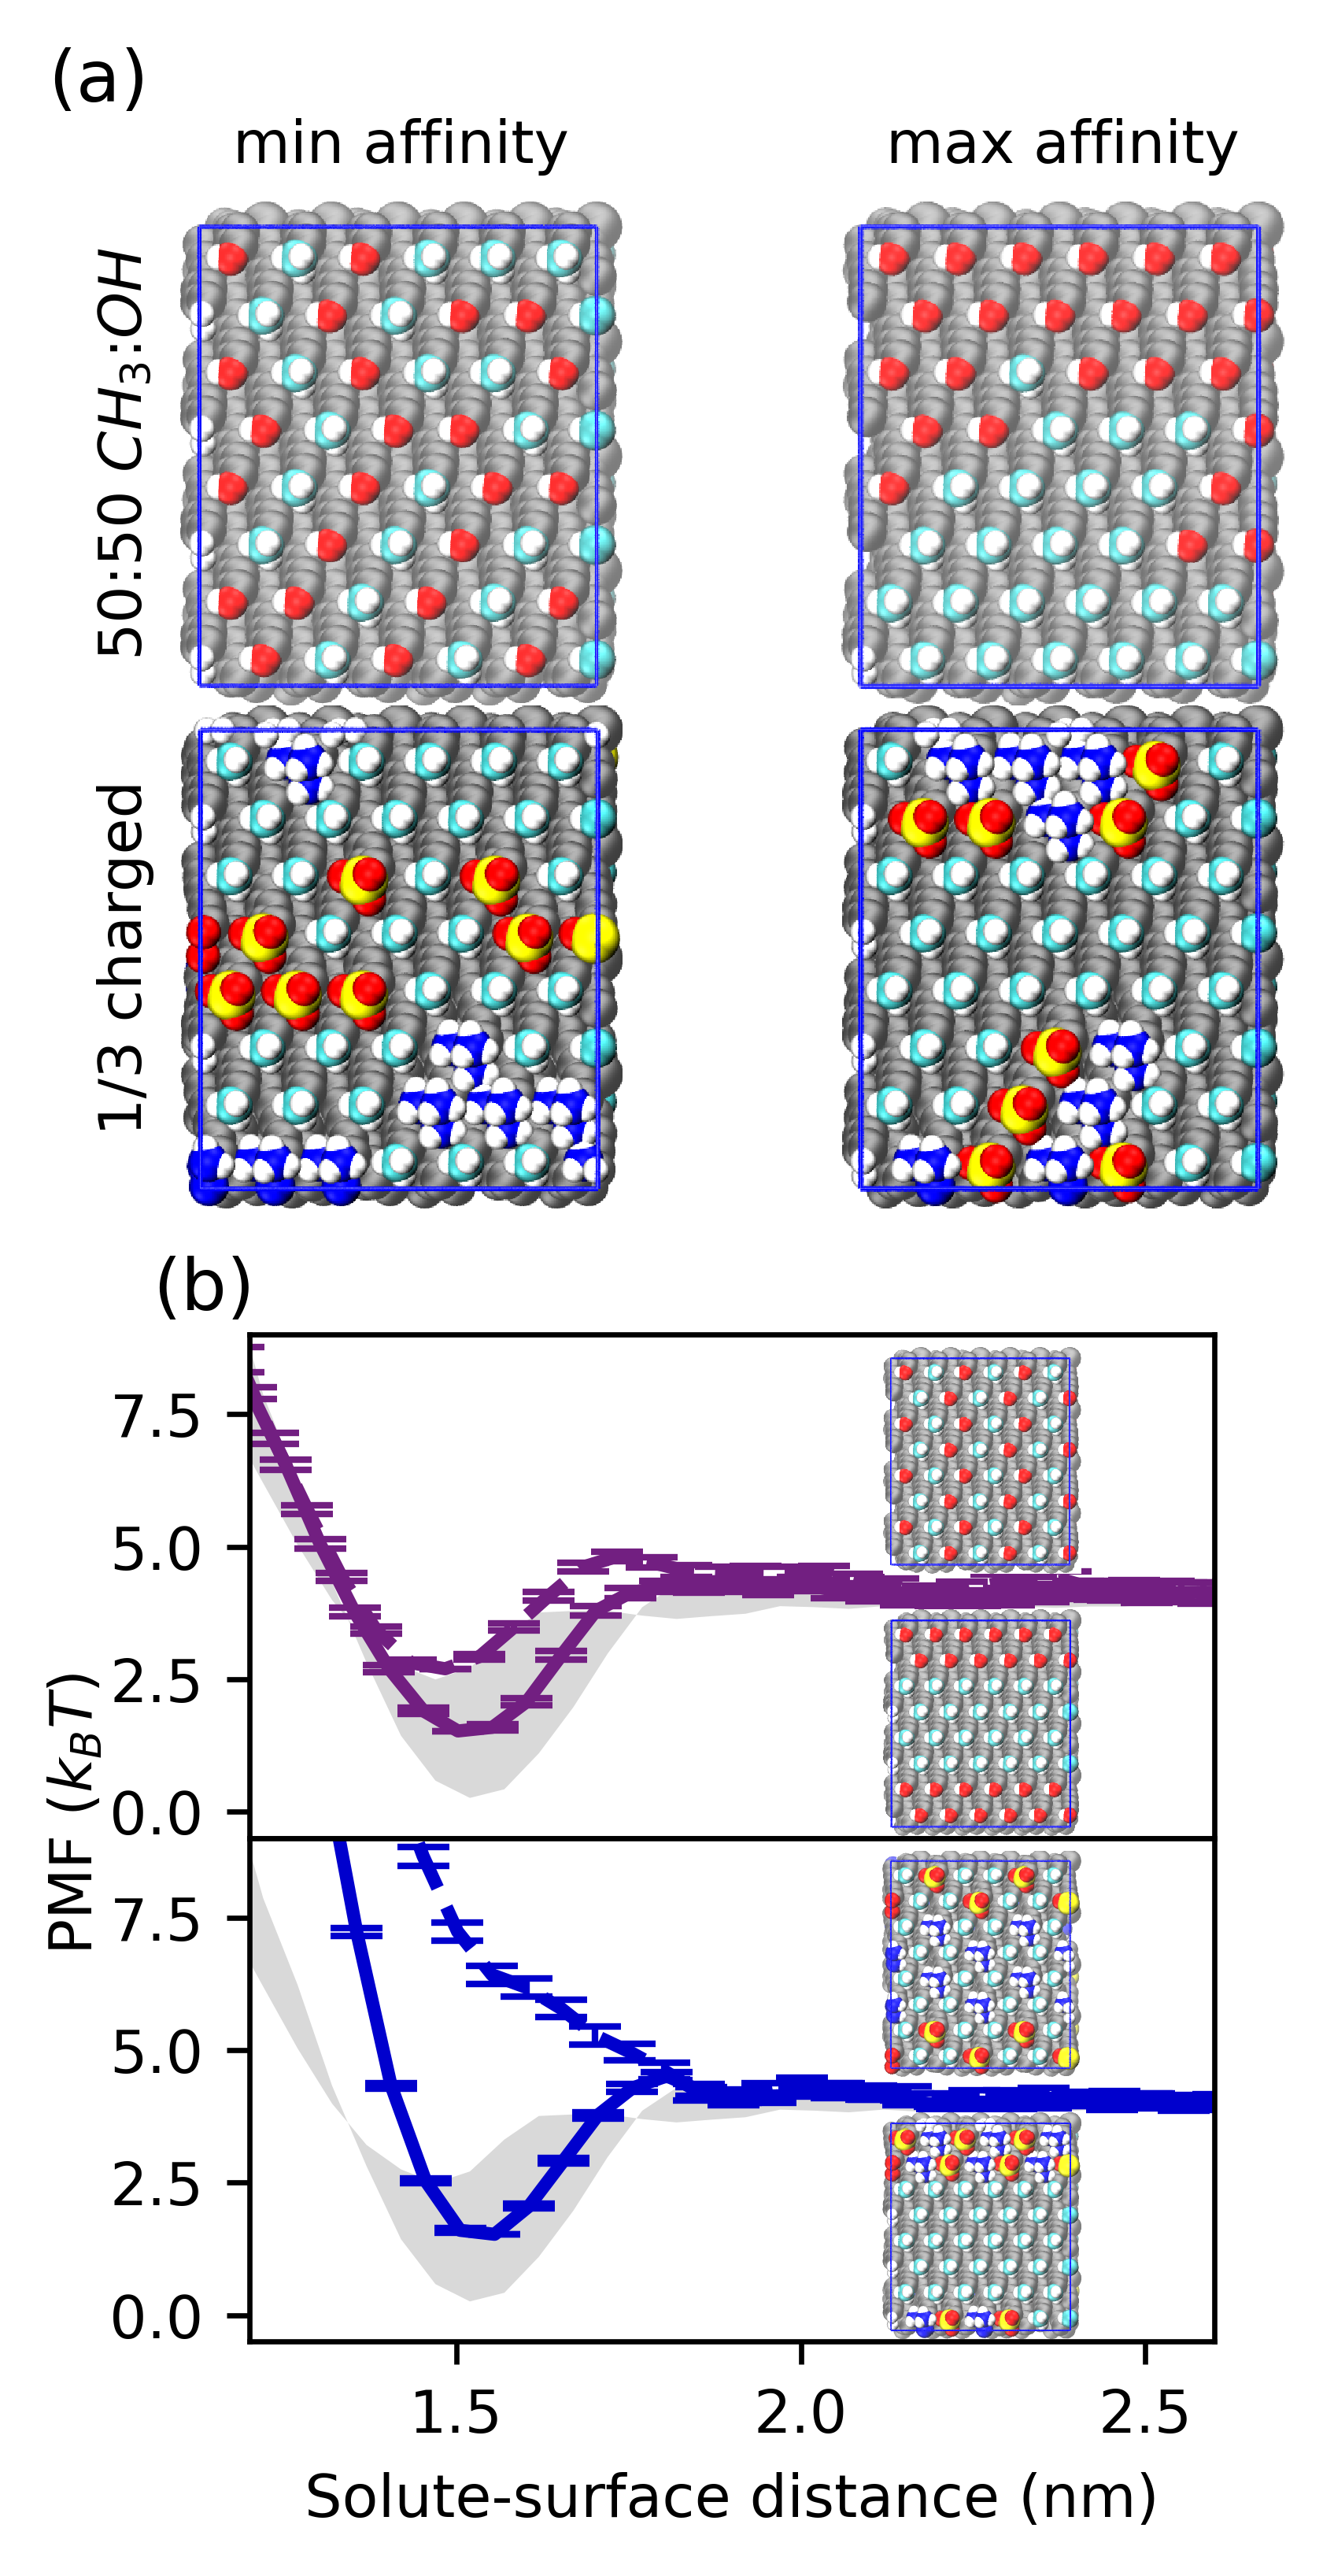

In [39]:
#Figure 4
#Methane PMFs for idealized surfaces, with surfaces as insets and annotations for binding affinities
#Surface images from various GA optimizations with text labels reporting binding affinity

from PIL import Image, ImageChops
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

#Found this function on StackOverflow
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

#Specify directories to pull PMFs from
pmfDirs = ['%s/umbrella_sampling/methane/%s'%(baseDir, f) for f in surfTypes+['charge_patch_spread', 'charge_spread_patch']]

#And images, too
#Set up directory where we have images
imgDir = '/Users/jacobmonroe/Documents/Shell_Lab/Figures'

#Show idealized images
idealFigs = ['fullCH3_top.dat.tga', 'fullOH_top.dat.tga', 
             'perfect_patch.dat.tga', 'perfect_spread.dat.tga', 
             'charge_patch_spread.dat.tga', 'charge_spread_patch.dat.tga']

insetBox = [(0.5, -0.06, 0.45, 0.45), 
            (0.5, 0.46, 0.45, 0.45), 
            (0.5, -0.06, 0.45, 0.45), 
            (0.5, 0.46, 0.45, 0.45),
            (0.5, -0.06, 0.45, 0.45), 
            (0.5, 0.46, 0.45, 0.45)]
# insetLocs = [4, 1, 4, 1, 4, 1]

#Specify colors for different surfaces
surfcmap = [plt.get_cmap('magma')(x) for x in np.arange(3)/3.0]
surfcolors = [surfcmap[0], surfcmap[2], surfcmap[1], surfcmap[1], 'mediumblue', 'mediumblue']
surfstyles = ['-', '-', '-', '--', '-', '--']

optFig = plt.figure(figsize=(3.54,6.0), dpi=600)
gspec = gridspec.GridSpec(ncols=8, nrows=17, figure=optFig, hspace=0)
pAx = np.array([optFig.add_subplot(gspec[9:13,1:7]), optFig.add_subplot(gspec[13:17,1:7])])

#Keep track of full PMFs to fill between
fullPlotPMFs = []

for i, f in enumerate(pmfDirs):
    thisPMF = np.loadtxt('%s/pmf.txt'%f)        
    
    #Want to shift each curve so it ends in bulk at its bulk solvation free energy
    toplot = thisPMF[:,1]
    toplot -= np.average(toplot[-3:])
    toplot += bulkdGs['methane'][0]
    
    if 'full' not in f:
            
        if 'half' in f:
            pAx[0].errorbar(thisPMF[:,0], toplot, yerr=thisPMF[:,2], label=f, linestyle=surfstyles[i],
                            color=surfcolors[i], ecolor=surfcolors[i], linewidth=2, elinewidth=1, capsize=4)
            imAx = inset_axes(pAx[0], width="100%", height="100%", 
                              loc=3, bbox_to_anchor=insetBox[i], bbox_transform=pAx[0].transAxes)
        elif 'charge' in f:
            pAx[1].errorbar(thisPMF[:,0], toplot, yerr=thisPMF[:,2], label=f, linestyle=surfstyles[i],
                            color=surfcolors[i], ecolor=surfcolors[i], linewidth=2, elinewidth=1, capsize=4)
            imAx = inset_axes(pAx[1], width="100%", height="100%", 
                              loc=3, bbox_to_anchor=insetBox[i], bbox_transform=pAx[1].transAxes)
        
        #Get image and plot in the inset axis
        thisim = Image.open('%s/%s'%(imgDir, idealFigs[i]))
        newim = trim(thisim)
        imAx.imshow(newim)
        imAx.set_xticks([])
        imAx.set_yticks([])
        for side in ['top', 'bottom', 'left', 'right']:
            imAx.spines[side].set_visible(False)
            
    else:
#         pAx[0].errorbar(thisPMF[:,0], toplot, yerr=thisPMF[:,2], label=f, linestyle=surfstyles[i],
#                         color=surfcolors[i], ecolor=surfcolors[i], linewidth=2, elinewidth=1, capsize=4)
#         pAx[1].errorbar(thisPMF[:,0], toplot, yerr=thisPMF[:,2], label=f, linestyle=surfstyles[i],
#                         color=surfcolors[i], ecolor=surfcolors[i], linewidth=2, elinewidth=1, capsize=4)
        fullPlotPMFs.append([thisPMF[:32,0], toplot[:32]])

#Fill between the CH3 and OH curves, and adjust axes to same scale
for ax in pAx:
    ax.fill_between(fullPlotPMFs[0][0], fullPlotPMFs[1][1], fullPlotPMFs[0][1],
                    facecolor='silver', interpolate=True, alpha=0.6)
    ax.tick_params(axis='both', labelsize=9)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))
    ax.set_xlim([1.2, 2.6])
    ax.set_ylim([-0.5, 9.0])

pAx[-1].set_xlabel(r'Solute-surface distance (nm)', fontsize=9)
pAx[-1].yaxis.set_label_coords(-0.15, 1.05)
pAx[-1].set_ylabel(r'PMF ($k_{B}T$)', fontsize=9)
pAx[0].set_xticks([])

pAx[0].annotate('(b)', xy=(-0.1, 1.05), xycoords='axes fraction', fontsize=11)

#Now set up just surface images
#Will only show optimizations for methane and methane-methanol selectivity
optFigs = [['GA_max_half.dat.tga', 'GA_min_half.dat.tga'],# 'sel_Me_MeOH_min.dat.tga'], 
          ['charged_max_methane.dat.tga', 'charged_min_methane.dat.tga']]#, 'sel_Me_MeOH_max.dat.tga']]

#Need grid spec axes for these, too
optAx = np.array([[optFig.add_subplot(gspec[:4,:4]), optFig.add_subplot(gspec[:4,4:])],
                  [optFig.add_subplot(gspec[4:8,:4]), optFig.add_subplot(gspec[4:8,4:])]])

for i in range(optAx.shape[0]):
    for j in range(optAx.shape[1]):
        thisim = Image.open('%s/%s'%(imgDir, optFigs[i][j]))
        newim = trim(thisim)
        optAx[i,j].imshow(newim)
        optAx[i,j].set_xticks([])
        optAx[i,j].set_yticks([])
        for side in ['top', 'bottom', 'left', 'right']:
            optAx[i,j].spines[side].set_visible(False)

optAx[0,0].set_title(r'min affinity', fontsize=9)
optAx[0,1].set_title(r'max affinity', fontsize=9)

optAx[0,0].set_ylabel(r'50:50 $CH_{3}$:$OH$', fontsize=9)
optAx[1,0].set_ylabel(r'1/3 charged', fontsize=9)
#optAx[1,2].set_xlabel(r'50:50 $CH_{3}$:$OH$ selectivity')

optAx[0,0].annotate('(a)', xy=(-0.30, 1.20), xycoords='axes fraction', fontsize=11)

#optFig.tight_layout()
#optFig.subplots_adjust(hspace=0)

plt.show()


LinregressResult(slope=0.8491861202324641, intercept=-0.28370229402997904, rvalue=0.9399193618706466, pvalue=5.483442066451652e-25, stderr=0.043620073817468644)
LinregressResult(slope=0.9211235191158715, intercept=0.26040690938537203, rvalue=0.9680683252075777, pvalue=1.0480116561927108e-31, stderr=0.03373321958627625)


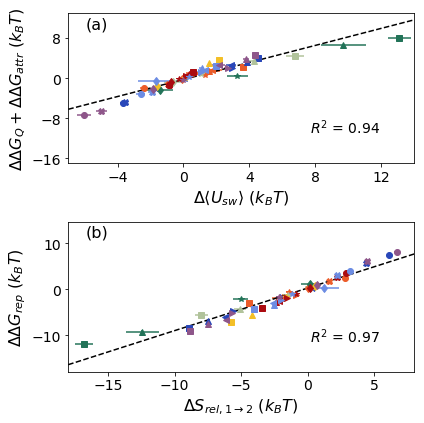

In [10]:
#Now just putting together SI figures

#Correlations between different binding free energy contributions
from scipy.stats import linregress

srelCorrFig, srelCorrAx = plt.subplots(2, sharex=False, sharey=False, figsize=(6,6))

allAvgU = []
allSrel = []
alldGattr = []
alldGrep = []

for i, sol in enumerate(solNames):
    
        for j, surf in enumerate(surfTypes):
            
            thisAvgU = surfAvgU["%s_%s"%(sol, surf)][0] - bulkAvgU[sol][0]
            thisAvgUerr = np.sqrt(surfAvgU["%s_%s"%(sol, surf)][1]**2 + bulkAvgU[sol][1]**2)/np.sqrt(5.0)
            thisdGattr = surfdGattr["%s_%s"%(sol, surf)][0]+surfdGq["%s_%s"%(sol, surf)][0] - (bulkdGattr[sol][0]+bulkdGq[sol][0])
            thisdGattrErr = np.sqrt(surfdGattr["%s_%s"%(sol, surf)][1]**2 + bulkdGattr[sol][1]**2 
                             + surfdGq["%s_%s"%(sol, surf)][1]**2 + bulkdGq[sol][1]**2)/np.sqrt(5.0)

            thisSrel = surfSrel["%s_%s"%(sol, surf)][0] - bulkSrel[sol][0]
            thisSrelErr = np.sqrt(surfSrel["%s_%s"%(sol, surf)][1]**2 + bulkSrel[sol][1]**2)/np.sqrt(5.0)
            thisdGrep = surfdGwca["%s_%s"%(sol, surf)][0] - bulkdGwca[sol][0]
            thisdGrepErr = np.sqrt(surfdGwca["%s_%s"%(sol, surf)][1]**2 + bulkdGwca[sol][1]**2)/np.sqrt(5.0)
            
            srelCorrAx[0].errorbar(thisAvgU, thisdGattr, xerr=thisAvgUerr, yerr=thisdGattrErr,
                                   color=solColors[i], marker=surfMarkers[j])
            srelCorrAx[1].errorbar(thisSrel, thisdGrep,  xerr=thisSrelErr, yerr=thisdGrepErr,
                                   color=solColors[i], marker=surfMarkers[j])
            
            allAvgU.append(thisAvgU)
            allSrel.append(thisSrel)
            alldGattr.append(thisdGattr)
            alldGrep.append(thisdGrep)
            
        if sol in chargeSolNames:
                            
            for j, csurf in enumerate(chargeSurfTypes):
                
                thiscAvgU = chargeAvgU["%s_%s"%(sol, csurf)][0] - bulkAvgU[sol][0]
                thiscAvgUerr = np.sqrt(chargeAvgU["%s_%s"%(sol, csurf)][1]**2 + bulkAvgU[sol][1]**2)/np.sqrt(5.0)
                thiscdGattr = chargedGattr["%s_%s"%(sol, csurf)][0]+chargedGq["%s_%s"%(sol, csurf)][0] - (bulkdGattr[sol][0]+bulkdGq[sol][0])
                thiscdGattrErr = np.sqrt(chargedGattr["%s_%s"%(sol, csurf)][1]**2 + bulkdGattr[sol][1]**2
                                         + chargedGq["%s_%s"%(sol, csurf)][1]**2 + bulkdGq[sol][1]**2)/np.sqrt(5.0)
                
                thiscSrel = chargeSrel["%s_%s"%(sol, csurf)][0] - bulkSrel[sol][0]
                thiscSrelErr = np.sqrt(chargedGwca["%s_%s"%(sol, csurf)][1]**2 + bulkdGwca[sol][1]**2)/np.sqrt(5.0)
                thiscdGrep = chargedGwca["%s_%s"%(sol, csurf)][0] - bulkdGwca[sol][0]
                thiscdGrepErr = np.sqrt(chargeSrel["%s_%s"%(sol, csurf)][1]**2 + bulkSrel[sol][1]**2)/np.sqrt(5.0)
                
                srelCorrAx[0].errorbar(thiscAvgU, thiscdGattr, xerr=thiscAvgUerr, yerr=thiscdGattrErr,
                                    color=solColors[i], marker=chargeSurfMarkers[j])
                srelCorrAx[1].errorbar(thiscSrel, thiscdGrep, xerr=thiscSrelErr, yerr=thiscdGrepErr,
                                    color=solColors[i], marker=chargeSurfMarkers[j])
                
                allAvgU.append(thiscAvgU)
                allSrel.append(thiscSrel)
                alldGattr.append(thiscdGattr)
                alldGrep.append(thiscdGrep)
            
for i, ax in enumerate(srelCorrAx):
    ax.tick_params(axis='both', labelsize=14)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=6, prune='both'))
        
srelCorrAx[0].set_xlabel(r'$\Delta \langle U_{sw} \rangle$ ($k_{B}T$)', fontsize=16)
srelCorrAx[0].set_ylabel(r'$\Delta \Delta G_{Q} + \Delta \Delta G_{attr}$ ($k_{B}T$)', fontsize=16)
srelCorrAx[1].set_xlabel(r'$\Delta S_{rel, 1 \rightarrow 2}$ ($k_{B}T$)', fontsize=16)
srelCorrAx[1].set_ylabel(r'$\Delta \Delta G_{rep}$ ($k_{B}T$)', fontsize=16)

#Look at correlations
attrReg = linregress(allAvgU, alldGattr)
repReg = linregress(allSrel, alldGrep)

print(attrReg)
print(repReg)

regXvals = np.array([-18, 14])
srelCorrAx[0].plot(regXvals, attrReg.slope*regXvals + attrReg.intercept, '--k')
srelCorrAx[1].plot(regXvals, repReg.slope*regXvals + repReg.intercept, '--k')

srelCorrAx[0].annotate(r'$R^2$ = %1.2f'%(attrReg.rvalue), xy=(0.7, 0.20), xycoords='axes fraction', fontsize=14)
srelCorrAx[1].annotate(r'$R^2$ = %1.2f'%(repReg.rvalue), xy=(0.7, 0.20), xycoords='axes fraction', fontsize=14)

srelCorrAx[0].annotate(r'(a)', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=16)
srelCorrAx[1].annotate(r'(b)', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=16)

srelCorrAx[0].set_xlim((-7, 14))
srelCorrAx[1].set_xlim((-18, 8))

srelCorrFig.tight_layout()


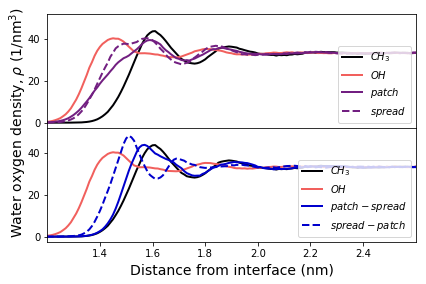

In [14]:
#Now look at water structure and ordering near the various interfaces
#Using the side of the interface without the solute - so only need to do once (done with the methane sims)
#Here look at density as a function of distance from both mean and instantaneous interfaces

zFig, zAx = plt.subplots(2, sharex=True, sharey=True)

#Define a color/style cycle to use for the 4 different surfaces
#Note that the last two surfaces are at the same hydroxyl density, but different patterns, so just change line style
surfcmap = [plt.get_cmap('magma')(x) for x in np.arange(3)/3.0]
surfcolors = [surfcmap[0], surfcmap[2], surfcmap[1], surfcmap[1], 'mediumblue', 'mediumblue']
surfstyles = ['-', '-', '-', '--', '-', '--']

surfTypesZ = surfTypes+['charged_dens_sixth/repeats_patch_spread', 'charged_dens_sixth/repeats_spread_patch']
surfLabelsZ = surfLabels+['patch-spread', 'spread-patch']

for i, surf in enumerate(surfTypesZ):
    
    zdat = np.loadtxt('%s/methane/%s/run1/z-densities.txt'%(baseDir, surf))
    meanshiftind = int(0.5*zdat.shape[0])
    meanshift = zdat[meanshiftind, 0]
    
    if i in [0,1]:
        zAx[0].plot(-(zdat[:,0] - meanshift)/10.0, 1000.0*zdat[:,2], label=r"$%s$"%surfLabelsZ[i], 
                    color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
        zAx[1].plot(-(zdat[:,0] - meanshift)/10.0, 1000.0*zdat[:,2], label=r"$%s$"%surfLabelsZ[i], 
                    color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
    elif i in [2,3]:
        zAx[0].plot(-(zdat[:,0] - meanshift)/10.0, 1000.0*zdat[:,2], label=r"$%s$"%surfLabelsZ[i], 
                    color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
    elif i in [4,5]:
        zAx[1].plot(-(zdat[:,0] - meanshift)/10.0, 1000.0*zdat[:,2], label=r"$%s$"%surfLabelsZ[i], 
                    color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)

zAx[0].legend(loc=4)
zAx[1].legend(loc=4)
zAx[0].set_xlim((1.2, 2.6))

zAx[1].set_xlabel(r'Distance from interface (nm)', fontsize=14)
zAx[1].set_ylabel(r'Water oxygen density, $\rho$ (1/nm$^3$)', fontsize=14)
zAx[1].yaxis.set_label_coords(-0.05, 1.05)

zAx[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, prune='both'))

zFig.tight_layout()
zFig.subplots_adjust(hspace=0)

plt.show()


/Users/jacobmonroe/Code/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


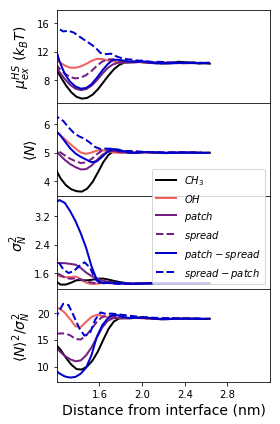

In [16]:
#Another figure for SI

muCheckFig, muCheckAx = plt.subplots(4, sharex=True, sharey=False, figsize=(4,6))

#Will define distances from surface where we took samples from
sliceZbins = np.arange(-6.0, 12.000001, 0.5)
sliceLocs = 0.5*(sliceZbins[1:] + sliceZbins[:-1])

for i, surf in enumerate(surfTypesZ):
    
    #Need to shift interface so reference is SU atoms to compare to PMFs, etc.
    zdat = np.loadtxt('%s/methane/%s/run1/z-densities.txt'%(baseDir, surf))
    meanshiftind = np.argmin(abs(zdat[:int(zdat.shape[0]/2),2] - 0.3*0.0332))
    meanshift = zdat[meanshiftind, 0]
    
    probedatmean = np.loadtxt('%s/methane/%s/run1/probe_hists_mean.txt'%(baseDir, surf))
    meanN = np.zeros(probedatmean.shape[1]-1)
    varN = np.zeros(probedatmean.shape[1]-1)
    for j in range(1, probedatmean.shape[1]):
        probedatmean[:,j] /= np.sum(probedatmean[:,j])
        meanN[j-1] = np.sum(probedatmean[:,0]*probedatmean[:,j])
        #varN[j-1] = np.sum(probedatmean[:,j]*(probedatmean[:,0]-meanN[j-1])**2)
        varN[j-1] = np.sum(probedatmean[:,j]*(probedatmean[:,0]**2)) - (meanN[j-1]**2)
    mumean = -np.log(probedatmean[0,1:])
    
    muCheckAx[0].plot((sliceLocs - meanshift)/10.0, mumean, label=r"$%s$"%surfLabelsZ[i],
                      color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
    muCheckAx[1].plot((sliceLocs - meanshift)/10.0, meanN, label=r"$%s$"%surfLabelsZ[i],
                      color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
    muCheckAx[2].plot((sliceLocs - meanshift)/10.0, varN, label=r"$%s$"%surfLabelsZ[i],
                      color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)
    muCheckAx[3].plot((sliceLocs - meanshift)/10.0, (meanN**2)/varN, label=r"$%s$"%surfLabelsZ[i],
                      color=surfcolors[i], linestyle=surfstyles[i], linewidth=2.0)

muCheckAx[2].legend(loc=4)

muCheckAx[0].set_xlim((1.2, 3.2))

for ax in muCheckAx:
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, prune='both'))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

muCheckAx[-1].set_xlabel(r'Distance from interface (nm)', fontsize=14)
muCheckAx[0].set_ylabel(r'$\mu_{ex}^{HS}$ ($k_{B}T$)', fontsize=14)
muCheckAx[1].set_ylabel(r'$\langle N \rangle$', fontsize=14)
muCheckAx[2].set_ylabel(r'$\sigma_{N}^2$', fontsize=14)
muCheckAx[3].set_ylabel(r'$\langle N \rangle^2 / \sigma_{N}^2$', fontsize=14)

muCheckFig.tight_layout()
muCheckFig.subplots_adjust(hspace=0)

plt.show()

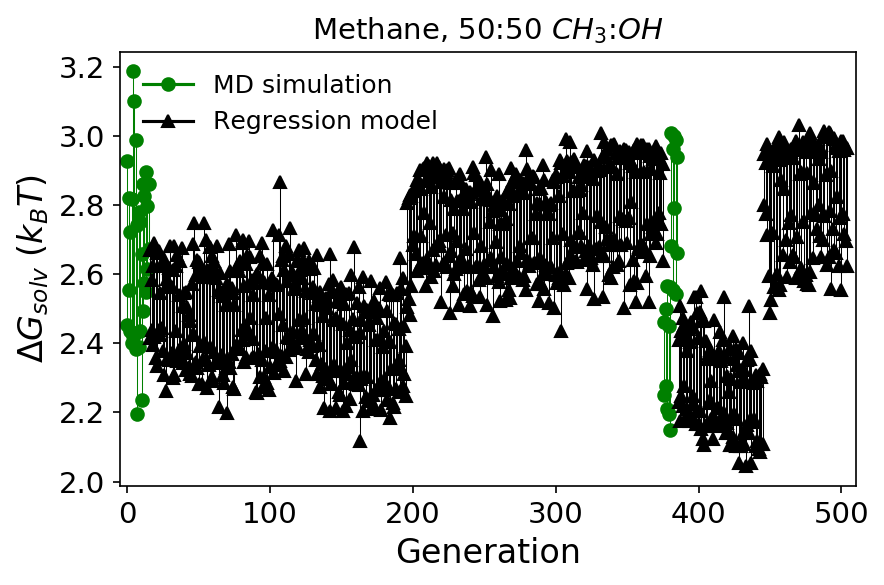

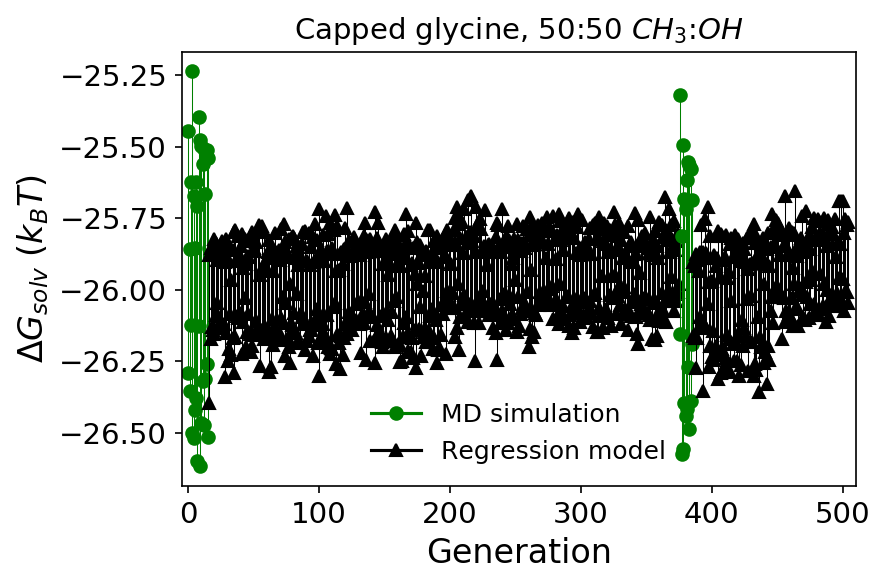

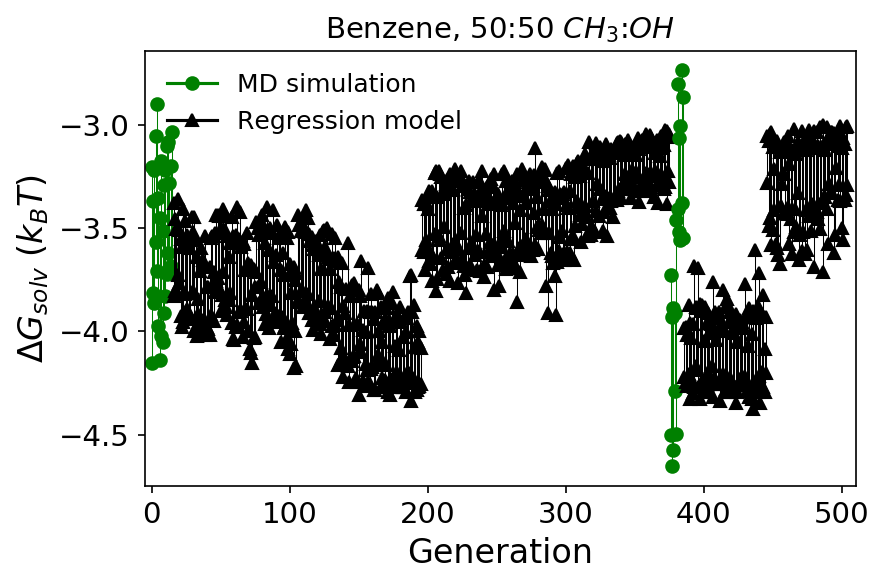

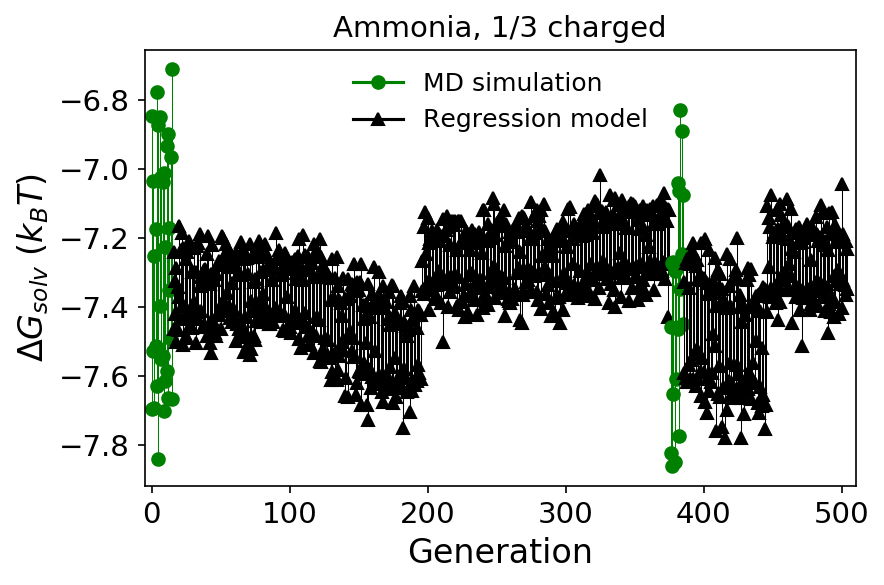

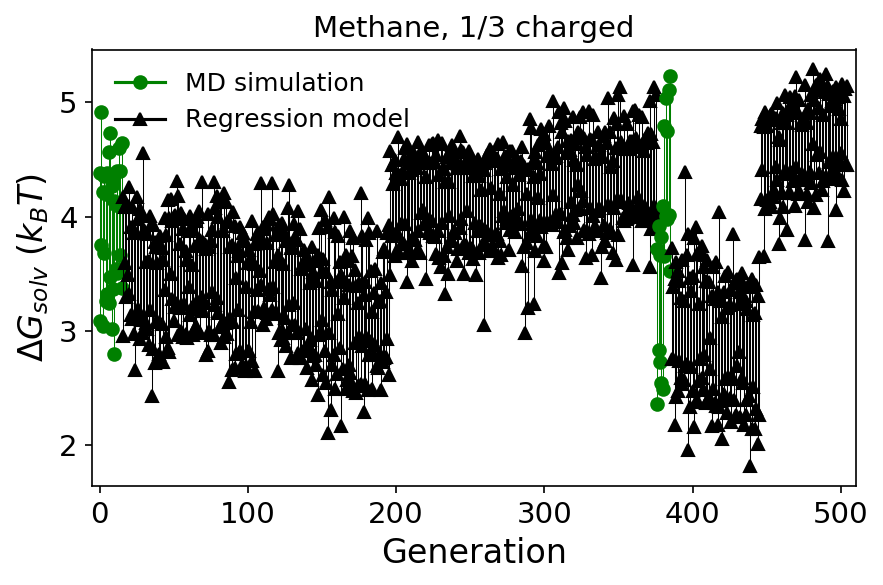

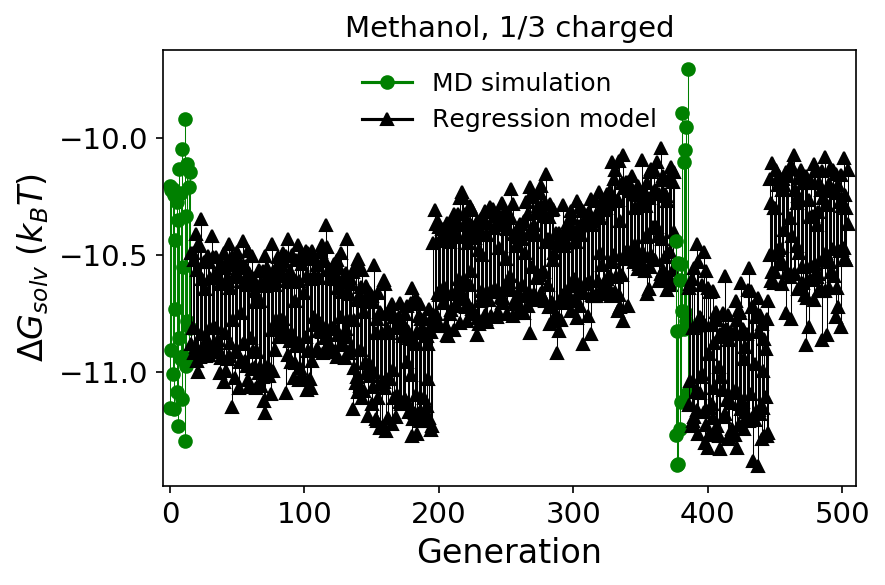

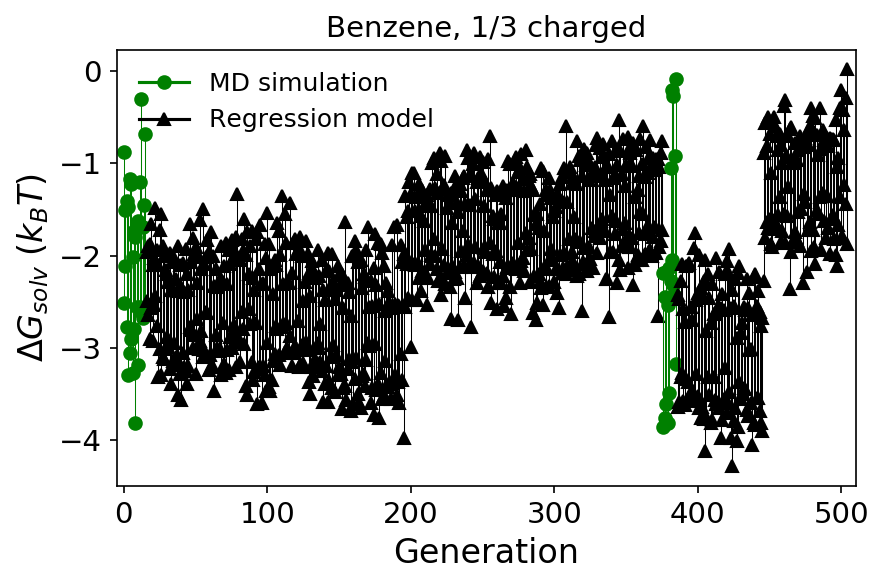

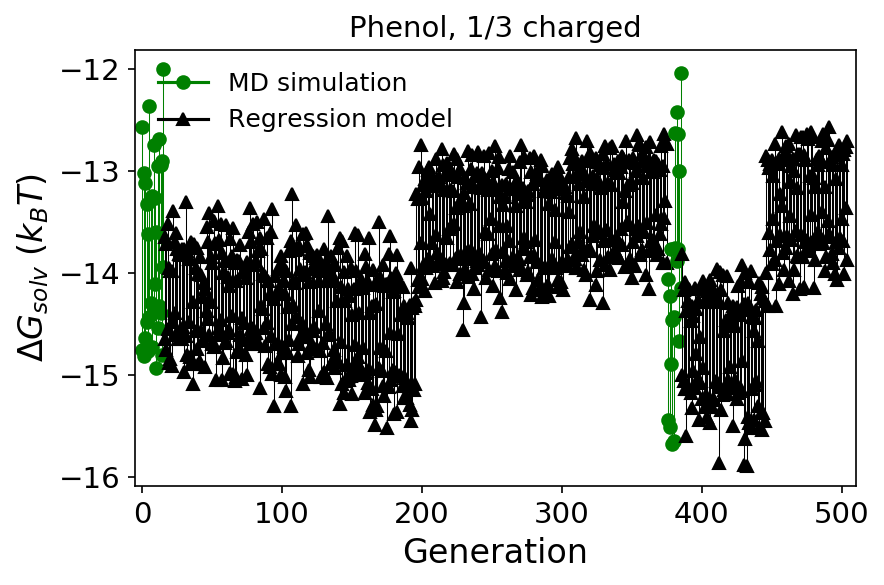

In [18]:
#Define function we will need to make a bunch of nice-looking figures for the SI, then make the figures
#These show the GA progression over each generation
def plotGA(surflib, title_text=None):
    #Get all solvation free energies, whether or not they were predicted by a model or MD, and their GA generation
    #After sorting by them, of course
    libdGs = np.array([surf.metric for surf in surflib])
    sortBydG = np.argsort(libdGs)
    surflib = [surflib[ind] for ind in sortBydG]
    libdGs = np.array([surf.metric for surf in surflib])
    libModelBool = np.array([surf.metricpredicted for surf in surflib])
    libGens = np.array([surf.gen for surf in surflib])

    #Sort by generation to look at a couple of things
    sortByGen = np.argsort(libGens)
    libdGsByGen = libdGs[sortByGen]
    libModelBoolByGen = libModelBool[sortByGen]
    surflibByGen = [surflib[ind] for ind in sortByGen]

    genFig, genAx = plt.subplots(dpi=150)

    #Set generation size and loop over generations, plotting line showing range for that generation
    #As we go, select points to use for annotation
    gensize = 8
    minModelPoint = [0, -100.0]
    maxModelPoint = [0, 100.0]
    minMDpoint = [0, 100.0]
    maxMDpoint = [0, -100.0]
    for agen in np.arange(0, np.max(libGens)):
        startind = int(agen*gensize)
        endind = int(agen*gensize + gensize)
        gendGs = libdGsByGen[startind:endind]
    
        thismin = np.min(gendGs)
        thismax = np.max(gendGs)
    
        if libModelBoolByGen[startind]:
            #If predicted by model, not with MD, use different symbol and color
            genAx.plot([agen, agen], [thismin, thismax], 'k-^', linewidth=0.5)
            if maxMDpoint[1] == -100.0:
                if thismax > minModelPoint[1]:
                    minModelPoint = [agen, thismax] #Using max because want above
                if thismin < maxModelPoint[1]:
                    maxModelPoint = [agen, thismin] #Intentionally using min since want below
        else:
            genAx.plot([agen, agen], [thismin, thismax], 'g-o', linewidth=0.5)
            if maxModelPoint[1] != 100.0:
                if thismin < minMDpoint[1]:
                    minMDpoint = [agen, thismin]
                if thismax > maxMDpoint[1]:
                    maxMDpoint = [agen, thismax]
    
    genAx.set_xlim((-5, 510))
    genAx.tick_params(axis='both', labelsize=14)
    genAx.set_xlabel(r'Generation', fontsize=16)
    genAx.set_ylabel(r'$\Delta G_{solv}$ ($k_{B}T$)', fontsize=16)

    legelements = [mpl.lines.Line2D([0], [0], color='g', marker='o', label='MD simulation'),
                   mpl.lines.Line2D([0], [0], color='k', marker='^', label='Regression model')]
    genAx.legend(handles=legelements, frameon=False, fontsize=12)

#     genAx.annotate('Minimization'+'\n'+'with model', xy=minModelPoint, xycoords='data')
#     genAx.annotate('Maximization'+'\n'+'with model', xy=maxModelPoint, xycoords='data')
#     genAx.annotate('Minimization'+'\n'+'with MD', xy=(minMDpoint[0], minMDpoint[1]*0.9), xycoords='data', 
#                    xytext=minMDpoint, textcoords='data',
#                    color='green', arrowprops=dict(facecolor='green', edgecolor='None', 
#                                                   width=2.0, headwidth=7.5, shrink=0.01))
#     genAx.annotate('Maximization'+'\n'+'with MD', xy=(maxMDpoint[0], maxMDpoint[1]*1.1), xycoords='data', 
#                    xytext=maxMDpoint, textcoords='data',
#                    color='green', arrowprops=dict(facecolor='green', edgecolor='None', 
#                                                   width=2.0, headwidth=7.5, shrink=0.01))

    if title_text is not None:
        genAx.set_title(title_text, fontsize=14)

    genFig.tight_layout()
    
    return genFig, genAx

#Start with methane
with open('%s/methane/dens_half/structure_library.pkl'%baseDir, 'r') as libfile:
    methanelib = pickle.load(libfile)
methaneFig, methaneAx = plotGA(methanelib, title_text=r'Methane, 50:50 $CH_{3}$:$OH$')

#Then capped glycine
with open('%s/capGLY/dens_half/structure_library.pkl'%baseDir, 'r') as libfile:
    capglylib = pickle.load(libfile)
capglyFig, capglyAx = plotGA(capglylib, title_text=r'Capped glycine, 50:50 $CH_{3}$:$OH$')

#And benzene
with open('%s/benzene/dens_half/structure_library.pkl'%baseDir, 'r') as libfile:
    benzenelib = pickle.load(libfile)
benzeneFig, benzeneAx = plotGA(benzenelib, title_text=r'Benzene, 50:50 $CH_{3}$:$OH$')

#Move to charged surfaces
#Ammonia
with open('%s/ammonia/charged_dens_sixth/structure_library.pkl'%baseDir, 'r') as libfile:
    chargeAmmonialib = pickle.load(libfile)
chargeAmmoniaFig, chargeAmmoniaAx = plotGA(chargeAmmonialib, title_text=r'Ammonia, 1/3 charged')

#Methane
with open('%s/methane/charged_dens_sixth/structure_library.pkl'%baseDir, 'r') as libfile:
    chargeMethanelib = pickle.load(libfile)
chargeMethaneFig, chargeMethaneAx = plotGA(chargeMethanelib, title_text=r'Methane, 1/3 charged')

#Methanol
with open('%s/methanol/charged_dens_sixth/structure_library.pkl'%baseDir, 'r') as libfile:
    chargeMethanollib = pickle.load(libfile)
chargeMethanolFig, chargeMethanolAx = plotGA(chargeMethanollib, title_text=r'Methanol, 1/3 charged')

#Benzene
with open('%s/benzene/charged_dens_sixth/structure_library.pkl'%baseDir, 'r') as libfile:
    chargeBenzenelib = pickle.load(libfile)
chargeBenzeneFig, chargeBenzeneAx = plotGA(chargeBenzenelib, title_text=r'Benzene, 1/3 charged')

#Phenol
with open('%s/phenol/charged_dens_sixth/structure_library.pkl'%baseDir, 'r') as libfile:
    chargePhenollib = pickle.load(libfile)
chargePhenolFig, chargePhenolAx = plotGA(chargePhenollib, title_text=r'Phenol, 1/3 charged')


plt.show()


In [5]:
#Need to print a bunch of things so easier to work with correlations based on molecular descriptors
print('\nBulk solvation:')
print('bulkdG, bulkdGq, bulkdGlj, bulkdGwca, bulkdGattr, bulkAvgU, bulkAvgUq, bulkAvgUlj, bulkAvgUwca, bulkAvgUattr, bulkSrel, bulkSrelQ, bulkSrelLJ, bulkSrelWCA, bulkSrelAttr')
for sol in solNames:
    infoVec = [bulkdGs[sol][1],
               bulkdGq[sol][1],
               bulkdGlj[sol][1],
               bulkdGwca[sol][1],
               bulkdGattr[sol][1],
               bulkAvgU[sol][1],
               bulkAvgUq[sol][1],
               bulkAvgUlj[sol][1],
               bulkAvgUwca[sol][1],
               bulkAvgUattr[sol][1],
               bulkSrel[sol][1],
               bulkSrelQ[sol][1],
               bulkSrelLJ[sol][1],
               bulkSrelWCA[sol][1],
               bulkSrelAttr[sol][1]]
    print('%s %s'%(sol, str(infoVec)))



Bulk solvation:
bulkdG, bulkdGq, bulkdGlj, bulkdGwca, bulkdGattr, bulkAvgU, bulkAvgUq, bulkAvgUlj, bulkAvgUwca, bulkAvgUattr, bulkSrel, bulkSrelQ, bulkSrelLJ, bulkSrelWCA, bulkSrelAttr
ammonia [0.14726988003390232, 0.09471717791562413, 0.08656590718175369, 0.09695026211826363, 0.01283391762869003, 0.27400475762019105, 0.2406716214652233, 0.015532100620972124, 0.02698005932165466, 0.012561581218142824, 0.3900065809871666, 0.32583450908290906, 0.07661324179800758, 0.0820680952167163, 0.002900002155171613]
benzene [0.1474168207458023, 0.11090807704040334, 0.1470302093693673, 0.2212572610544126, 0.0962546757150017, 0.31483286187070675, 0.2719824889901922, 0.07102747925063926, 0.09671073467201025, 0.04132734513974941, 0.32321219482686614, 0.1811476418883226, 0.18320742516257396, 0.20825856772699683, 0.0606797167124238]
boricacid [0.20805398470901734, 0.12284012281905313, 0.17487278128885575, 0.19309867774715542, 0.04037743330128828, 0.9754795342239128, 1.2958483676650994, 0.018390495528941

In [6]:
print('\nSurface solvation:')
for surf in surfTypes:
    print(surf)
    print('surfdG, surfdGq, surfdGlj, surfdGwca, surfdGattr, surfAvgU, surfAvgUq, surfAvgUlj, surfAvgUwca, surfAvgUattr, surfSrel, surfSrelQ, surfSrelLJ, surfSrelWCA, surfSrelAttr')
    for sol in solNames:
        infoVec = [surfdGs['%s_%s'%(sol, surf)][1],
                   surfdGq['%s_%s'%(sol, surf)][1],
                   surfdGlj['%s_%s'%(sol, surf)][1],
                   surfdGwca['%s_%s'%(sol, surf)][1],
                   surfdGattr['%s_%s'%(sol, surf)][1],
                   surfAvgU['%s_%s'%(sol, surf)][1],
                   surfAvgUq['%s_%s'%(sol, surf)][1],
                   surfAvgUlj['%s_%s'%(sol, surf)][1],
                   surfAvgUwca['%s_%s'%(sol, surf)][1],
                   surfAvgUattr['%s_%s'%(sol, surf)][1],
                   surfSrel['%s_%s'%(sol, surf)][1],
                   surfSrelQ['%s_%s'%(sol, surf)][1],
                   surfSrelLJ['%s_%s'%(sol, surf)][1],
                   surfSrelWCA['%s_%s'%(sol, surf)][1],
                   surfSrelAttr['%s_%s'%(sol, surf)][1]]
        print('%s %s'%(sol, str(infoVec)))



Surface solvation:
fullCH3
surfdG, surfdGq, surfdGlj, surfdGwca, surfdGattr, surfAvgU, surfAvgUq, surfAvgUlj, surfAvgUwca, surfAvgUattr, surfSrel, surfSrelQ, surfSrelLJ, surfSrelWCA, surfSrelAttr
ammonia [0.14081688245838989, 0.09887246494954964, 0.06783615470234138, 0.06811590020178841, 0.02256754197293106, 0.31962804828034147, 0.4170237283117121, 0.013996101017783393, 0.030533125879935702, 0.02037709779875427, 0.22248655780473534, 0.3537575486014401, 0.07125866749245315, 0.09061971838788731, 0.007514841269115403]
benzene [0.16688383247397004, 0.05132749757001607, 0.13231625568009392, 0.17625176900048423, 0.16716602151155022, 0.16182580423158782, 0.10000688720883198, 0.014157034445814665, 0.08851322920727722, 0.14497486695458578, 0.13200843142504287, 0.05669183583903418, 0.1216585544616573, 0.13293841278276167, 0.05020814036588086]
boricacid [0.12403383678658013, 0.10219570712706082, 0.07899813878820185, 0.42796072794965656, 0.304925110152149, 0.766487384582615, 1.0045299062354978, 0

In [7]:
print('\nCharged surface solvation:')
for charge in chargeSurfTypes:
    print(charge)
    print('chargedG, chargedGq, chargedGlj, chargedGwca, chargedGattr, chargeAvgU, chargeAvgUq, chargeAvgUlj, chargeAvgUwca, chargeAvgUattr, chargeSrel, chargeSrelQ, chargeSrelLJ, chargeSrelWCA, chargeSrelAttr')
    for sol in chargeSolNames:
        infoVec = [chargedGs['%s_%s'%(sol, charge)][1],
                   chargedGq['%s_%s'%(sol, charge)][1],
                   chargedGlj['%s_%s'%(sol, charge)][1],
                   chargedGwca['%s_%s'%(sol, charge)][1],
                   chargedGattr['%s_%s'%(sol, charge)][1],
                   chargeAvgU['%s_%s'%(sol, charge)][1],
                   chargeAvgUq['%s_%s'%(sol, charge)][1],
                   chargeAvgUlj['%s_%s'%(sol, charge)][1],
                   chargeAvgUwca['%s_%s'%(sol, charge)][1],
                   chargeAvgUattr['%s_%s'%(sol, charge)][1],
                   chargeSrel['%s_%s'%(sol, charge)][1],
                   chargeSrelQ['%s_%s'%(sol, charge)][1],
                   chargeSrelLJ['%s_%s'%(sol, charge)][1],
                   chargeSrelWCA['%s_%s'%(sol, charge)][1],
                   chargeSrelAttr['%s_%s'%(sol, charge)][1]]
        print('%s %s'%(sol, str(infoVec)))



Charged surface solvation:
patch_patch
chargedG, chargedGq, chargedGlj, chargedGwca, chargedGattr, chargeAvgU, chargeAvgUq, chargeAvgUlj, chargeAvgUwca, chargeAvgUattr, chargeSrel, chargeSrelQ, chargeSrelLJ, chargeSrelWCA, chargeSrelAttr
ammonia [0.1577597735599923, 0.1905808518233141, 0.055175473879251966, 0.03458086899862395, 0.016877407961532608, 1.247818547736328, 1.2505296733765254, 0.014322017829202689, 0.019864443493337488, 0.025250717979891157, 1.0908710764447374, 1.068640261613561, 0.06166274381423535, 0.04054686347548957, 0.010973499382603532]
methane [0.06599793095241686, 0.0012132268130897864, 0.06523874287721984, 0.18555226978617087, 0.01606135262983775, 0.039606640179394366, 0.0012105671398150537, 0.03791569687477734, 0.03569326383226951, 0.051241260794402894, 0.0706511594087456, 7.69382869577951e-05, 0.07111994000067753, 0.21566431968408642, 0.045224649718930934]
methanol [0.22860423459616863, 0.18898695645281943, 0.1161004032314272, 0.13964550135324819, 0.0424693624475

In [29]:
print(octdGs)

{'benzene': array([-5.9190896 ,  0.16336408]), 'isopropanol': array([-11.4085586 ,   1.05090949]), 'boricacid': array([-2.2526286 ,  0.20498848]), 'capGLY': array([-22.363384  ,   0.74849435]), 'methanol': array([-8.9548246 ,  0.40002192]), 'phenol': array([-15.2175664 ,   0.61613933]), 'ammonia': array([-3.0883616 ,  0.12957652]), 'methane': array([0.3860748 , 0.06011576])}
